Tratar CSV

In [2]:
import datetime
import pandas as pd
import re
from datetime import datetime, timedelta

def corrigir_diferenca_tempo(dataframe):
    dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')

    time_diff = dataframe['datetime'].diff()
    time_diff = time_diff.fillna(pd.Timedelta(seconds=0))
    time_diff = time_diff.apply(lambda x: pd.Timedelta(minutes=1) if x.total_seconds() == 1 else x)

    dataframe['datetime'] = dataframe['datetime'] + time_diff.cumsum()

    dataframe['datetime'] = dataframe['datetime'].apply(lambda dt: dt.replace(second=0))
    
    return dataframe

def timestamp_para_datahora(timestamp):
    datahora = datetime.datetime.fromtimestamp(timestamp)
    return datahora

def merge_dataframe(df, group_size=60):
    # Cria o dataframe auxiliar
    df_merged = pd.DataFrame()

    # Loop pelos grupos de tamanho "group_size"
    for i in range(0, len(df), group_size):
        # Seleciona o grupo atual
        df_group = df.iloc[i:i+group_size,:]

        # Loop pelas colunas do grupo
        for col in df_group.columns:

            # Verifica se a coluna é a datetime
            if col == 'datetime':
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Ajusta apenas a hora mantendo os minutos
                col_value = col_value.replace(minute=0, second=0)

            else:
                # Armazena o valor da primeira linha da coluna
                col_value = df_group[col].iloc[0]

                # Loop pelas linhas da coluna
                for j in range(1, len(df_group)):

                    # Verifica se o valor atual é maior ou menor que o valor armazenado
                    if df_group[col].iloc[j] > col_value:
                        # Soma a diferença na variável armazenada
                        col_value += df_group[col].iloc[j] - col_value
                        
                    elif df_group[col].iloc[j] < col_value:
                        # Soma a diferença na variável armazenada
                        col_value -= col_value - df_group[col].iloc[j]

            # Insere a coluna e valor no dataframe auxiliar
            df_merged.loc[i//group_size, col] = col_value

    return df_merged

def encontrar_valor_em_dataframe(dataframe, valor):
    row = dataframe[dataframe['datetime'] == valor].index.item()
    return row

def subtrair_uma_hora(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(hours=1)
    return nova_data_hora.strftime(formato)

def subtrair_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora - timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def somar_uma_semana(valor):
    formato = '%Y-%m-%d %H:%M:%S'
    data_hora = datetime.strptime(valor, formato)
    nova_data_hora = data_hora + timedelta(weeks=1)
    return nova_data_hora.strftime(formato)

def formatar_dataframeSemMerge(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return dataframe

def formatar_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Converter a coluna "time" para valores numéricos e filtrar os valores nulos e não numéricos
    dataframe['time'] = pd.to_numeric(dataframe['time'], errors='coerce')
    dataframe = dataframe[~dataframe['time'].isna()]

    # Converter a coluna "time" para timestamp e criar a coluna "datetime"
    dataframe = corrigir_diferenca_tempo(dataframe)

    # Apagar a coluna "time", "summary", "icon", "cloudCover"
    dataframe = dataframe.drop(columns=['time', 'summary', 'icon', 'cloudCover'])

    # Ordena alfabeticamente as colunas
    dataframe = dataframe.sort_index(axis=1)

    return merge_dataframe(dataframe)

Salvar CSV Tratado

In [3]:
import pandas as pd

filepath = '../Files/HomeCTratado.csv'
dataframe = formatar_dataframe(pd.read_csv('../Files/HomeC.csv', delimiter=',', low_memory=False))

dataframe.to_csv(filepath, index=False)

C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\686250430.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')
C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\686250430.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'] = dataframe['datetime'] + time_diff.cumsum()
C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\686250430.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Treinar modelo

In [4]:
from sklearn.ensemble import IsolationForest
import pandas as pd

#Abrir CSV ja tratado
df = pd.read_csv('../Files/HomeCTratado.csv', delimiter=',', low_memory=False)

#Colunas que não envolvem KW
exclude_columns = ['apparentTemperature','datetime','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed']

#Salvar todos os dados do dataframe menos as colunas acima
X = df[[column for column in list(df.columns) if column not in exclude_columns]]

#Definir padrões pro algoritmo
isolation_forest = IsolationForest(n_estimators=100, contamination='auto')

#Treinar o algoritmo
isolation_forest.fit(X)

#Achar as anomalias
y_pred = isolation_forest.predict(X)

#Adicionar nova coluna dizendo se é ou não anomalia
df['anomaly'] = y_pred

#Dataframe somente com anomalias
anomaly = df.loc[df['anomaly'] == -1]

anomaly

Barn [kW]  Dishwasher [kW]  Fridge [kW]  Furnace 1 [kW]  Furnace 2 [kW]   
18     0.035883         0.000050     0.593800        0.486150        0.658983  \
23     0.034200         1.231283     0.136100        0.492267        0.680150   
24     0.034550         1.366750     0.003850        0.493400        0.071683   
41     0.493183         0.000017     0.037283        0.316250        0.676550   
66     0.029383         0.000083     0.017833        0.021367        0.653133   
...         ...              ...          ...             ...             ...   
8247   0.028883         1.336417     0.003317        0.634250        0.072383   
8295   0.029750         0.000083     0.125283        0.070383        0.664367   
8335   0.029150         0.000217     0.004650        0.439733        0.063750   
8375   0.032017         0.119467     0.135683        0.496117        0.063383   
8383   0.029150         0.000250     0.089300        0.497117        0.062500   

      Garage door [kW]  Home office [kW]  House overall [kW]  Kitchen 12 [kW]   
18            0.012333          0.041833            5.359650         0.000617  \
23            0.011467          0.051483            2.908333         0.000467   
24            0.011017          0.051950            2.094050         0.000933   
41            0.012267          0.090567            2.772533         0.000850   
66            0.013300          0.171517            2.207400         0.000633   
...                ...               ...                 ...              ...   
8247          0.010817          0.556333            2.668050         0.000983   
8295          0.154300          0.040517            1.467100         0.000283   
8335          0.012283          0.040250            2.590267         0.000733   
8375          0.012183          0.042617            2.735383         0.000500   
8383          0.012350          0.040667            2.716633         0.000517   

      Kitchen 14 [kW]  ...  humidity  precipIntensity  precipProbability   
18           0.000650  ...      0.70           0.0000               0.00  \
23           0.000833  ...      0.60           0.0000               0.00   
24           0.001317  ...      0.60           0.0000               0.00   
41           0.000067  ...      0.57           0.0000               0.00   
66           0.000233  ...      0.69           0.0000               0.00   
...               ...  ...       ...              ...                ...   
8247         0.001683  ...      0.87           0.0164               0.57   
8295         0.000250  ...      0.50           0.0000               0.00   
8335         0.000350  ...      0.68           0.0000               0.00   
8375         0.000333  ...      0.81           0.0000               0.00   
8383         0.000350  ...      0.78           0.0000               0.00   

      pressure  temperature  use [kW]  visibility windBearing  windSpeed   
18     1013.62        32.87  5.359650        8.06       273.0       9.14  \
23     1014.19        30.04  2.908333       10.00       275.0       8.02   
24     1014.24        29.56  2.094050       10.00       273.0       8.04   
41     1014.28        33.22  2.772533       10.00       244.0       6.59   
66     1010.23        32.80  2.207400       10.00       217.0       4.14   
...        ...          ...       ...         ...         ...        ...   
8247   1021.29        35.34  2.668050        3.64       186.0       8.85   
8295   1038.71        31.30  1.467100       10.00       152.0       4.55   
8335   1014.94        33.92  2.590267        9.94       291.0       9.58   
8375    995.90        32.63  2.735383        9.17       279.0       9.44   
8383    998.04        30.18  2.716633        9.03       227.0       9.04   

      anomaly  
18         -1  
23         -1  
24         -1  
41         -1  
66         -1  
...       ...  
8247       -1  
8295       -1  
8335       -1  
8375       -1  
8383       -1  

[475 rows x 30 columns]

C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\2266765045.py:4: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))
C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\686250430.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['datetime'] = pd.to_datetime(dataframe['time'], unit='s')
C:\Users\gabri\AppData\Local\Temp\ipykernel_21428\686250430.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

ValueError: can only convert an array of size 1 to a Python scalar

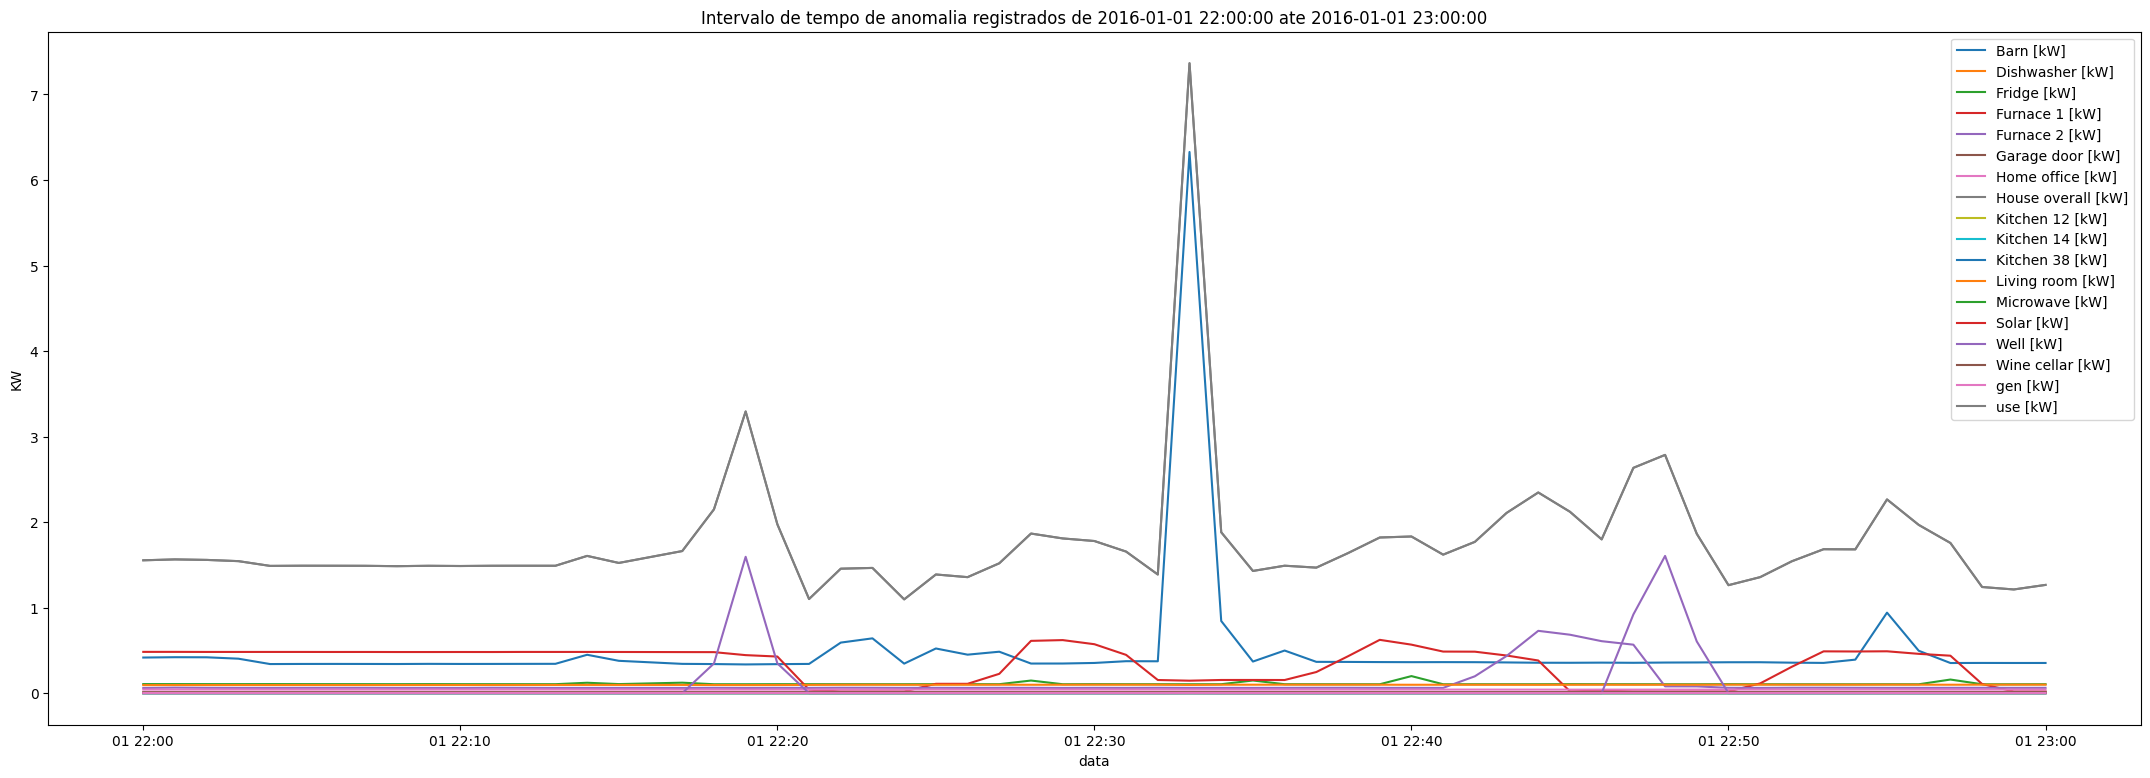

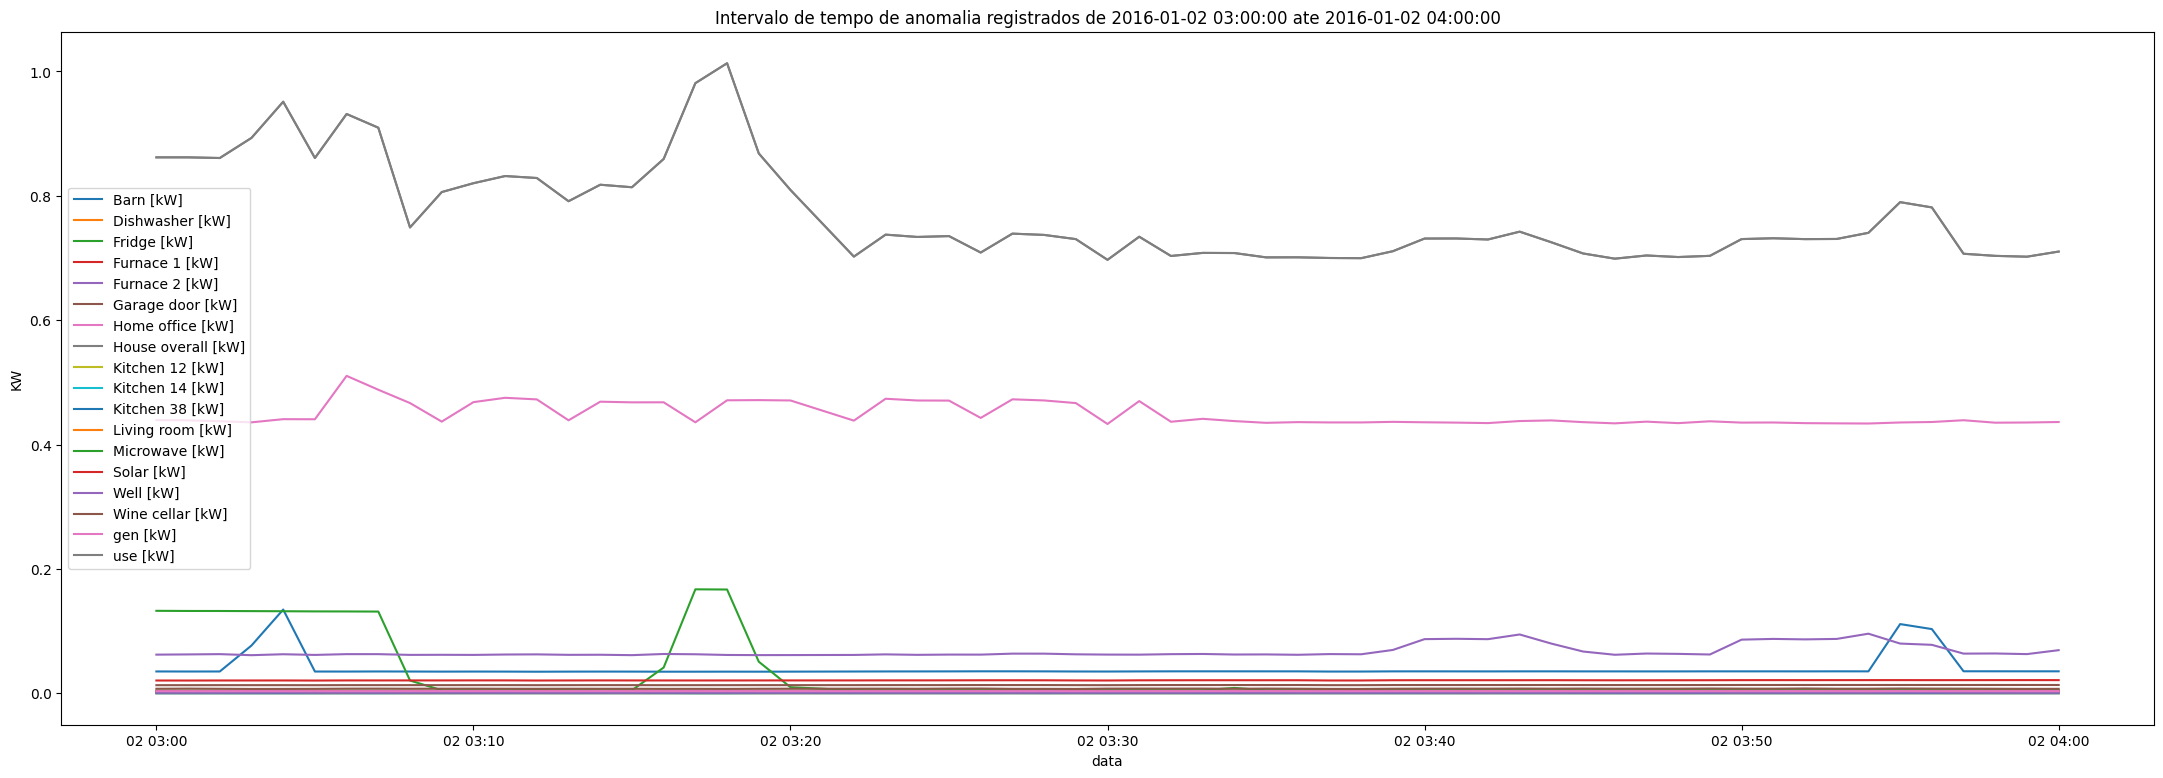

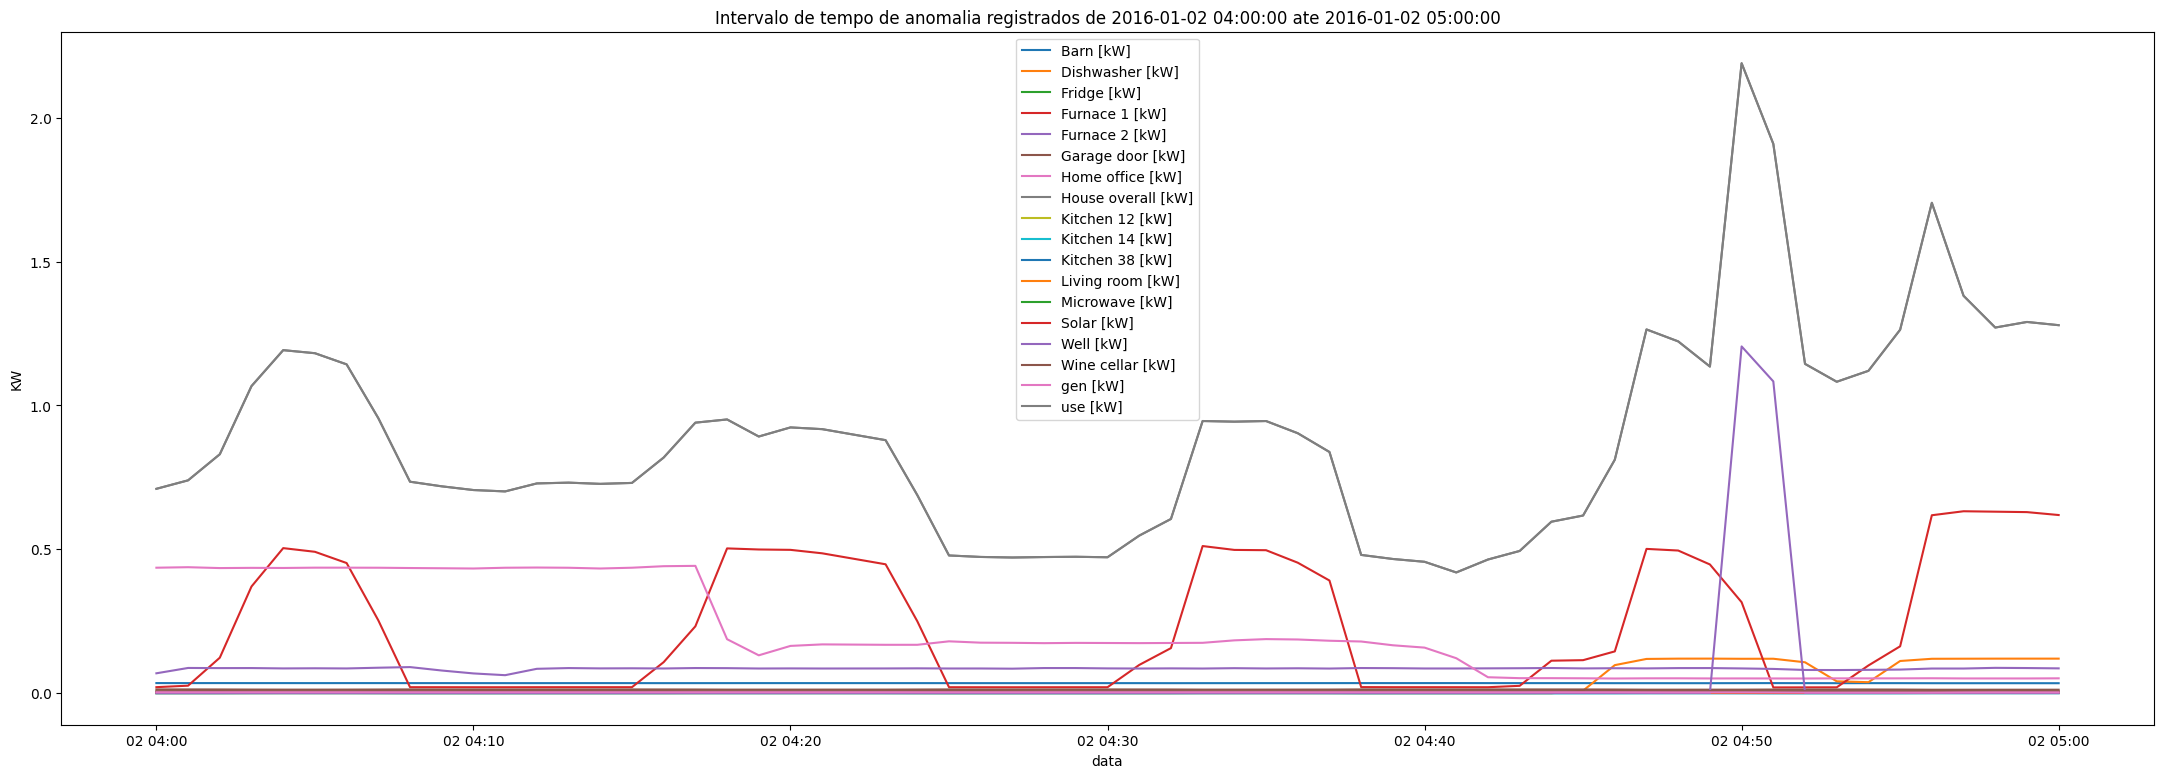

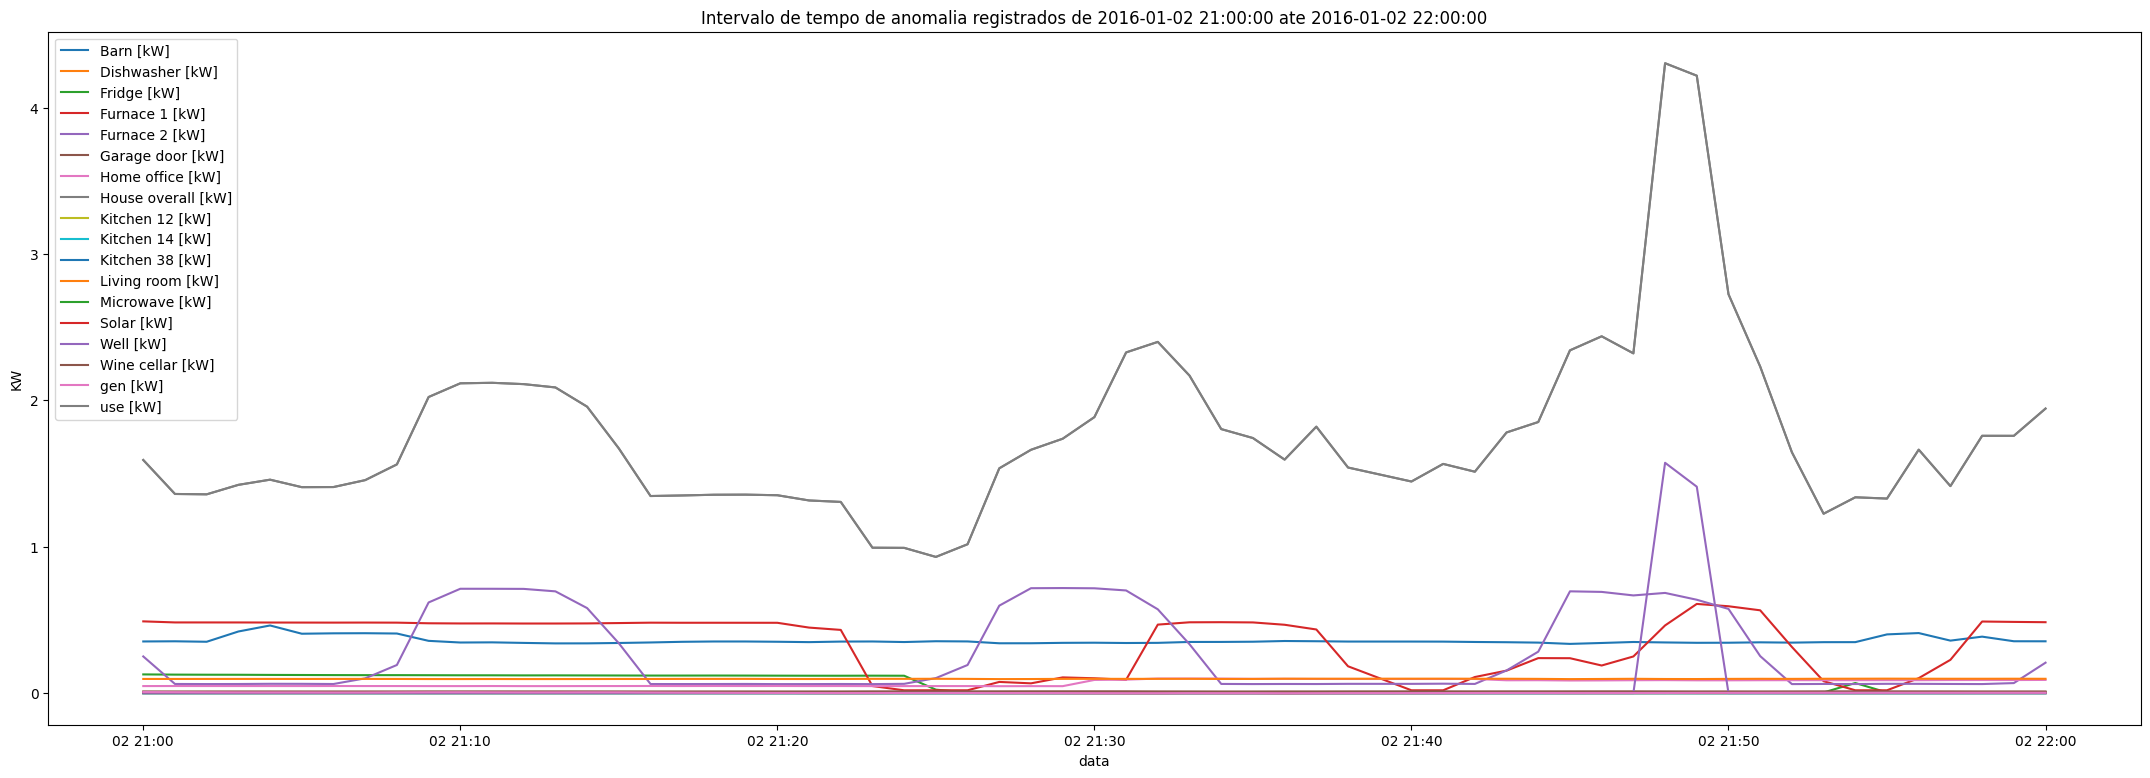

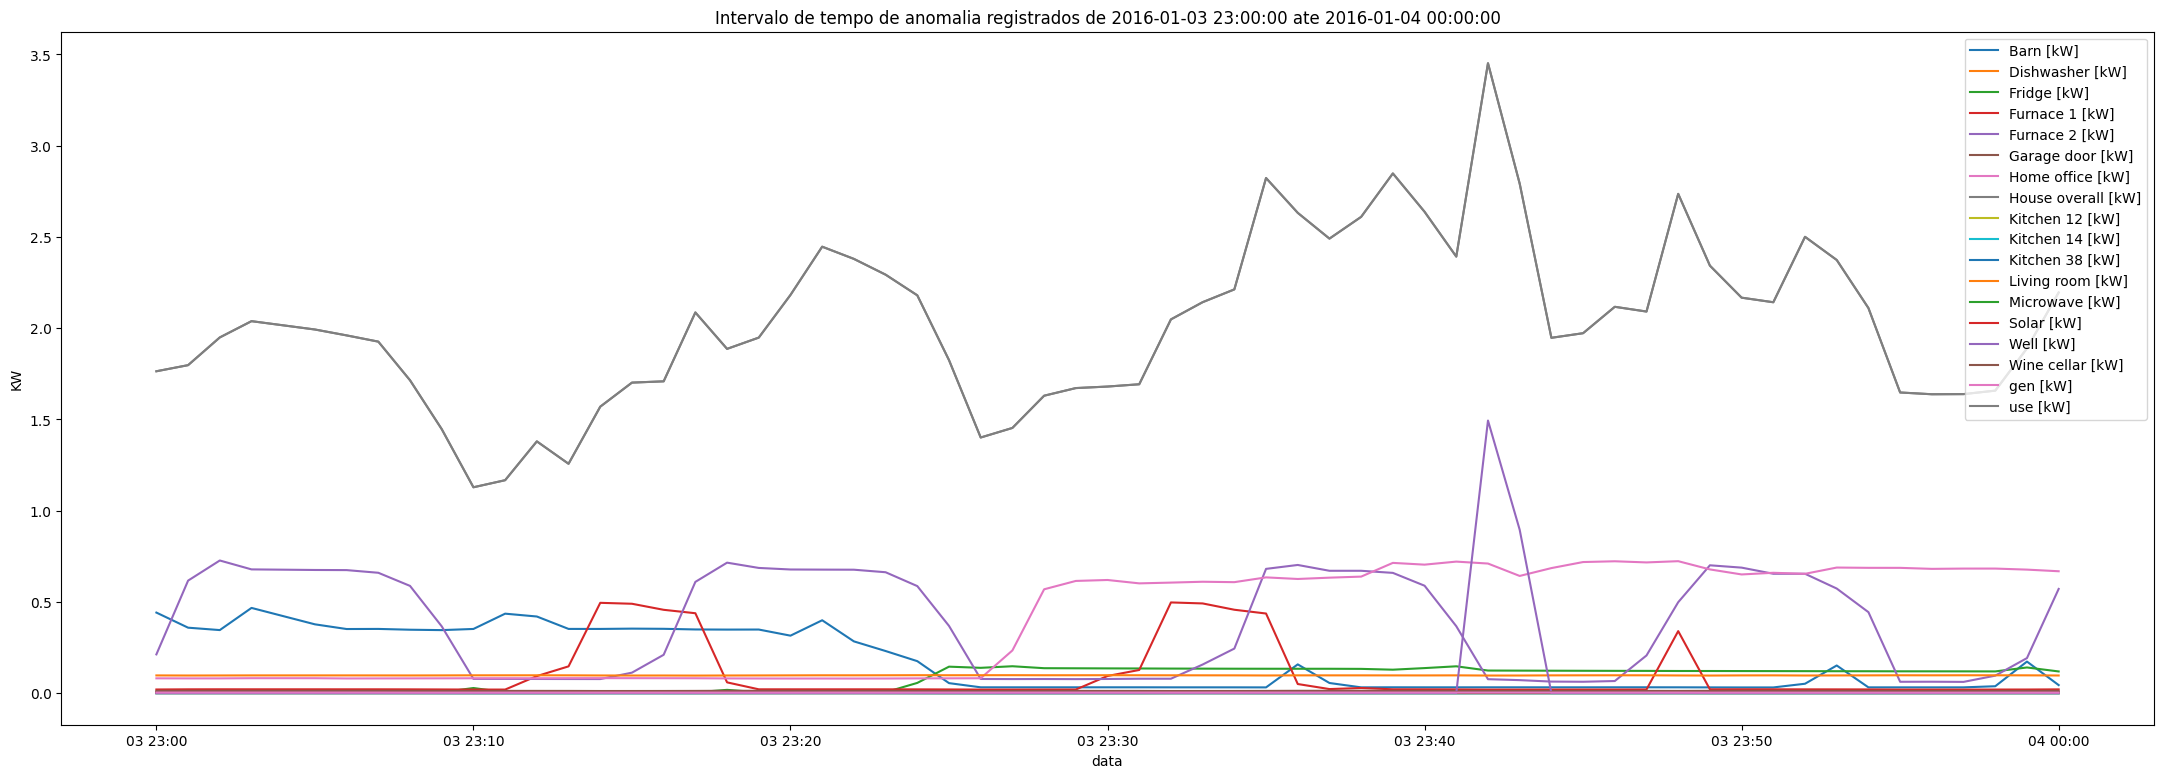

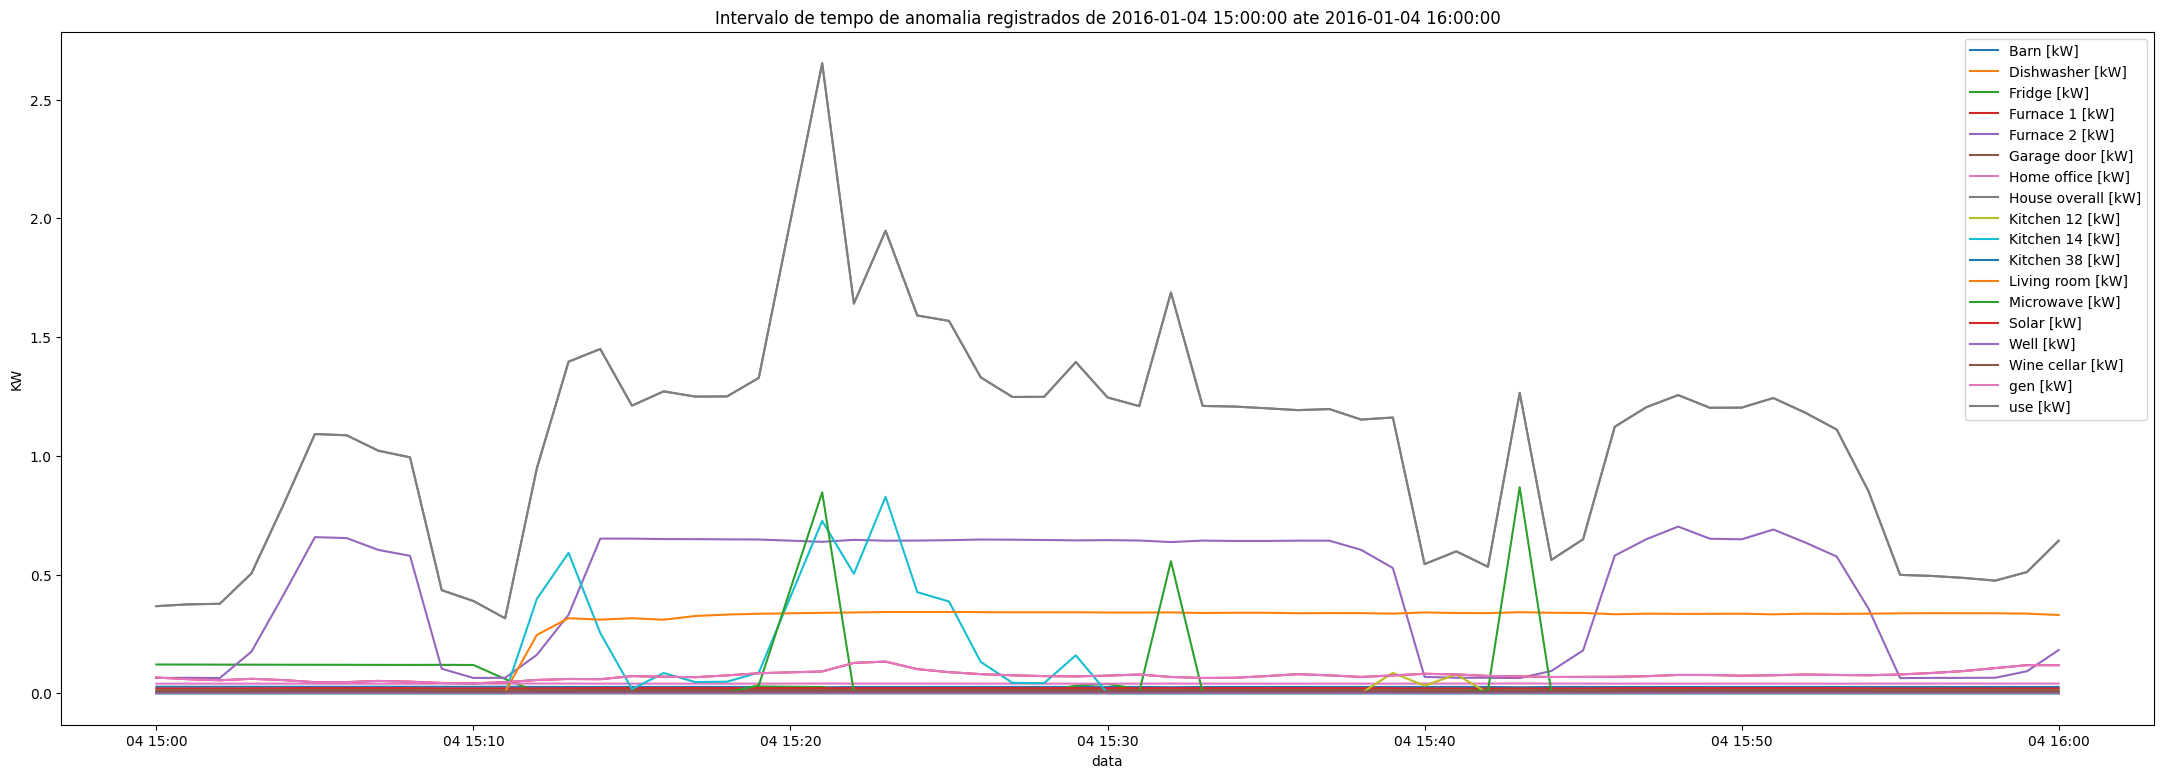

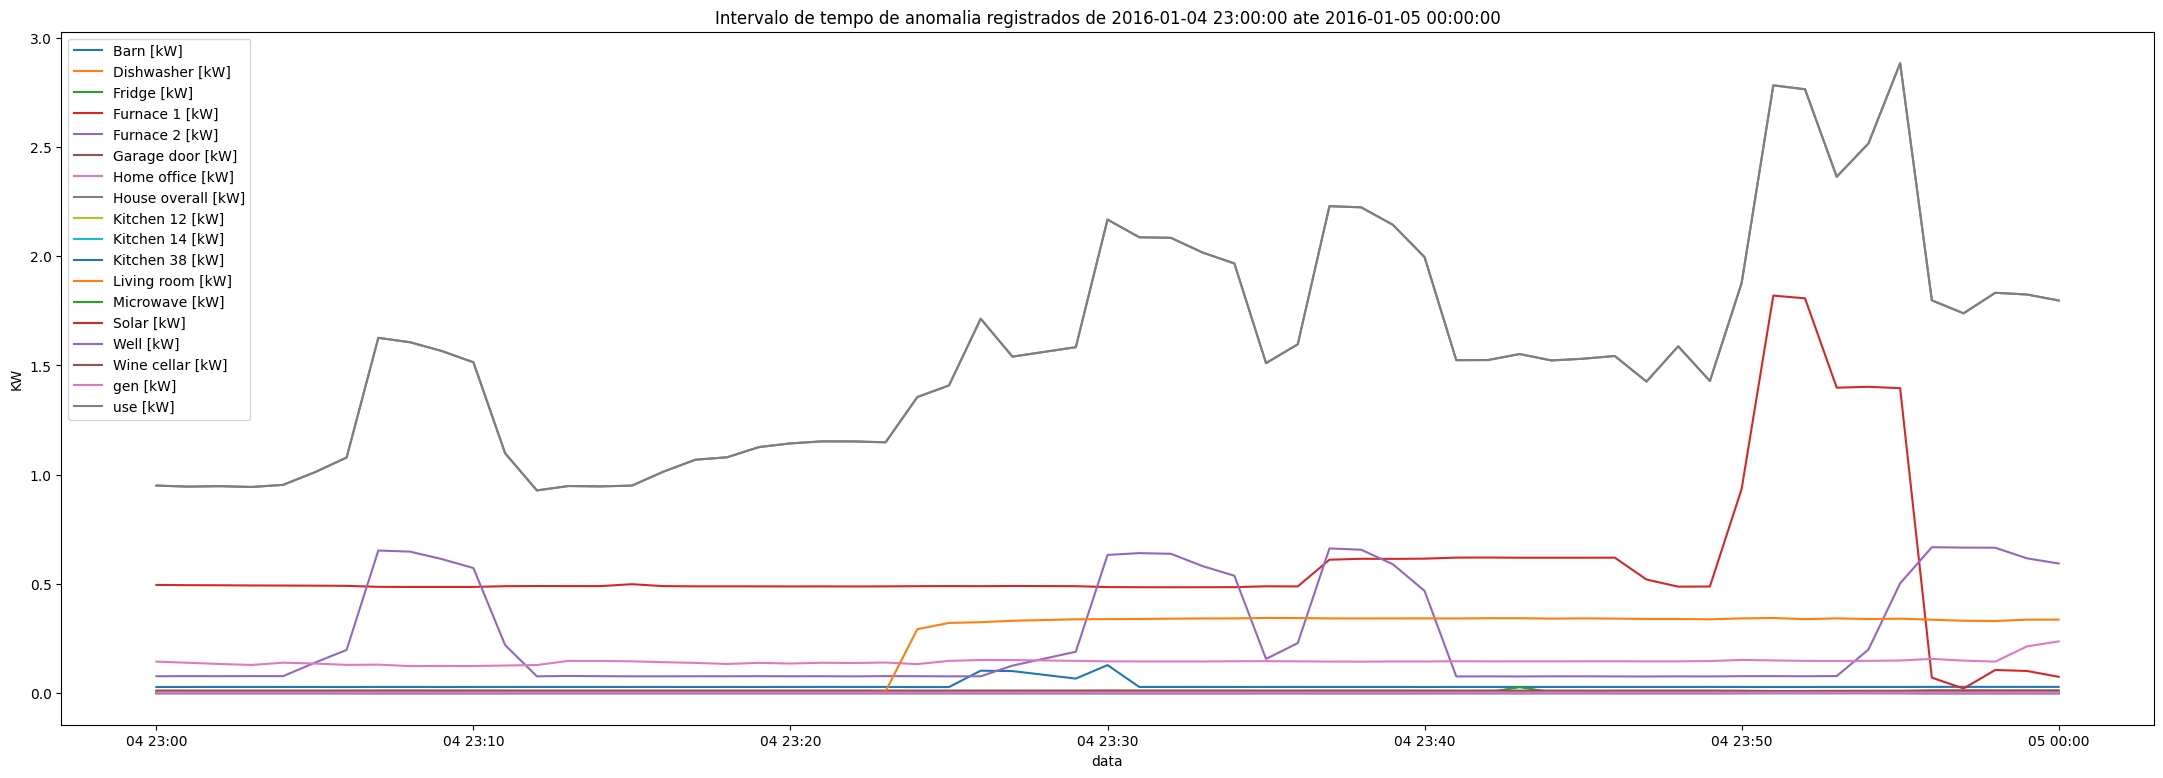

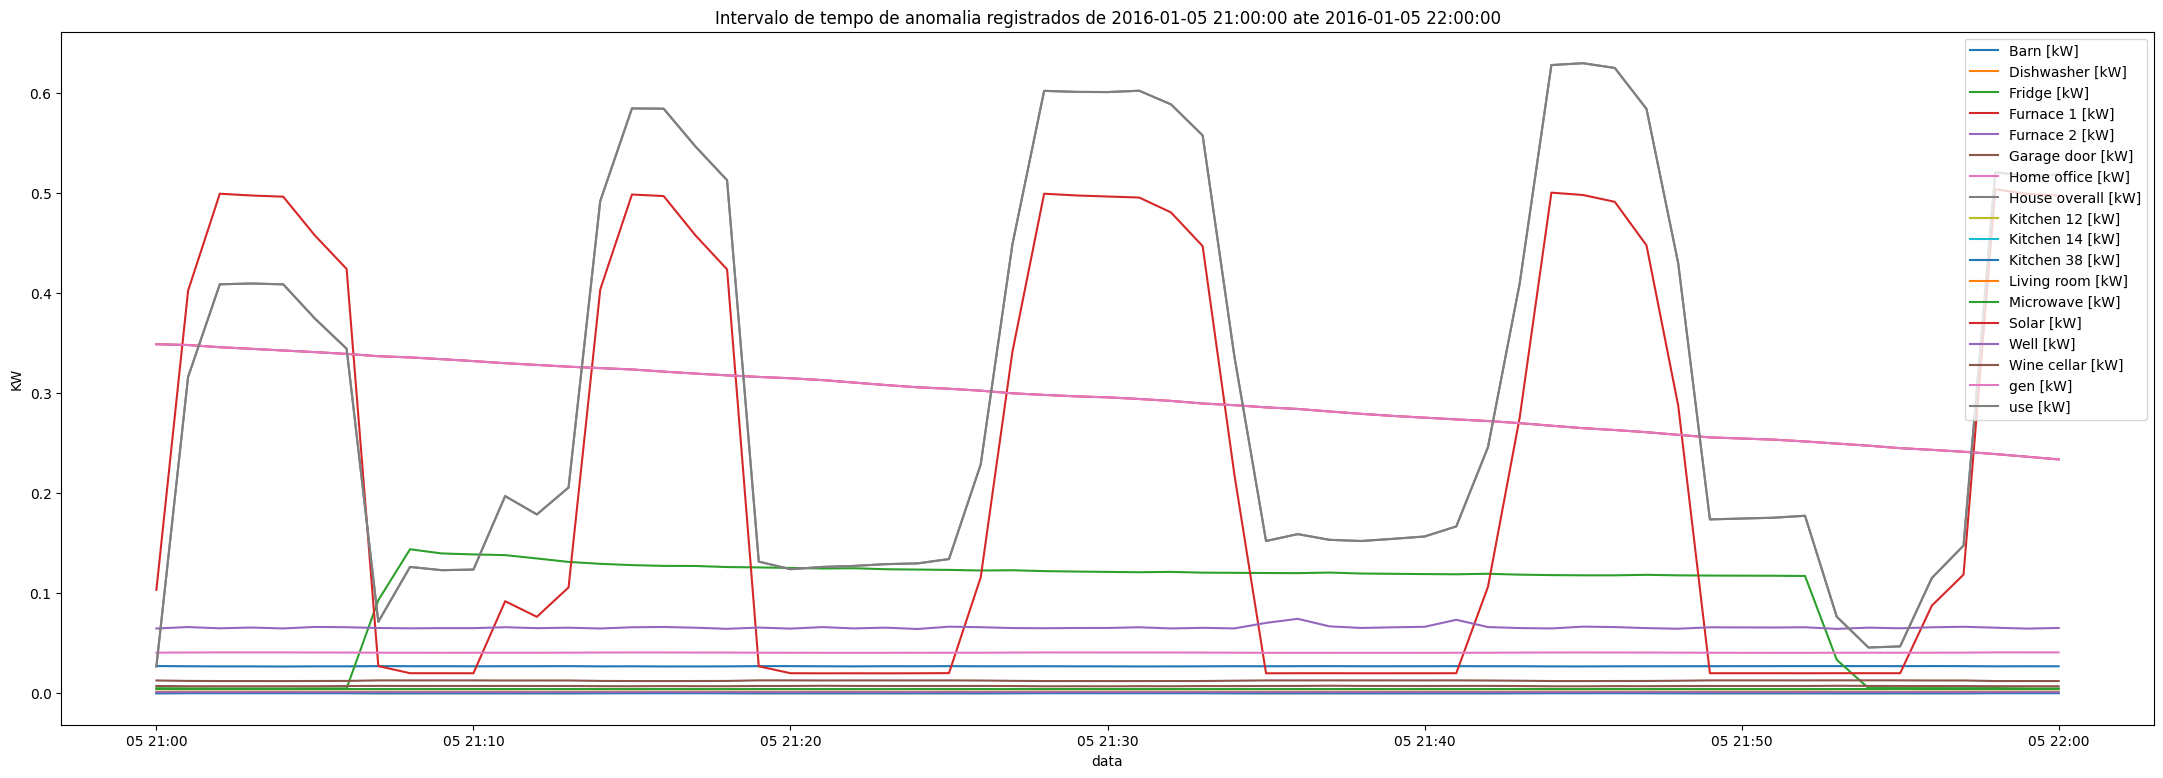

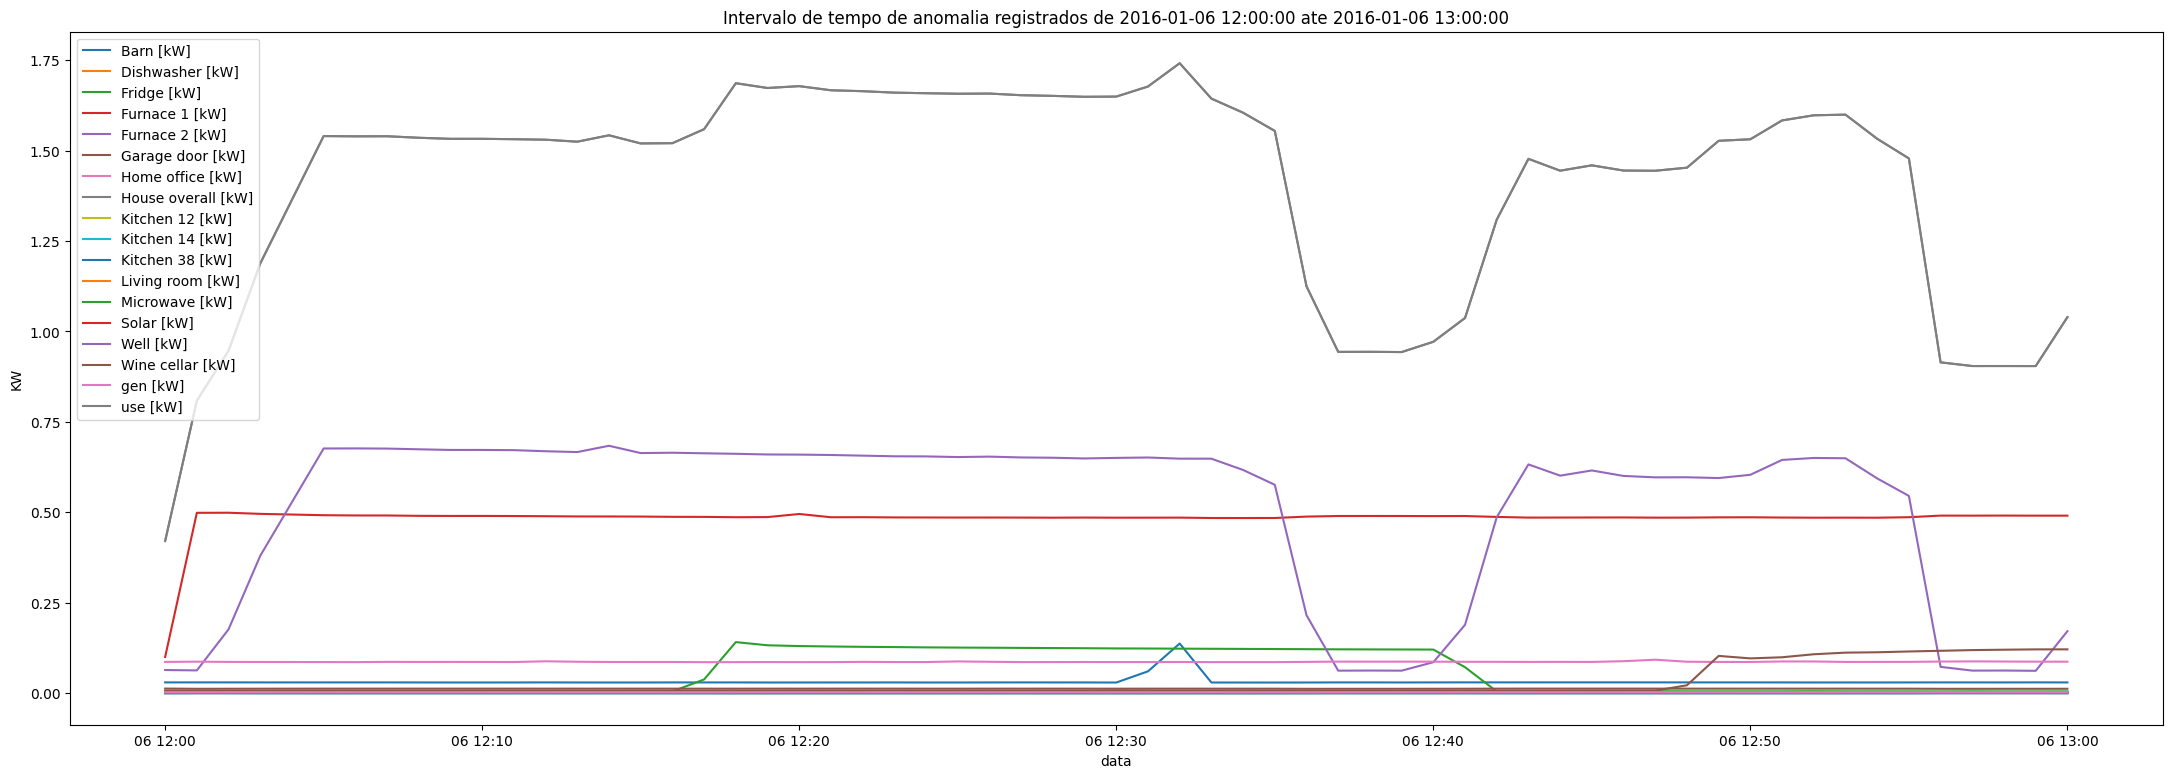

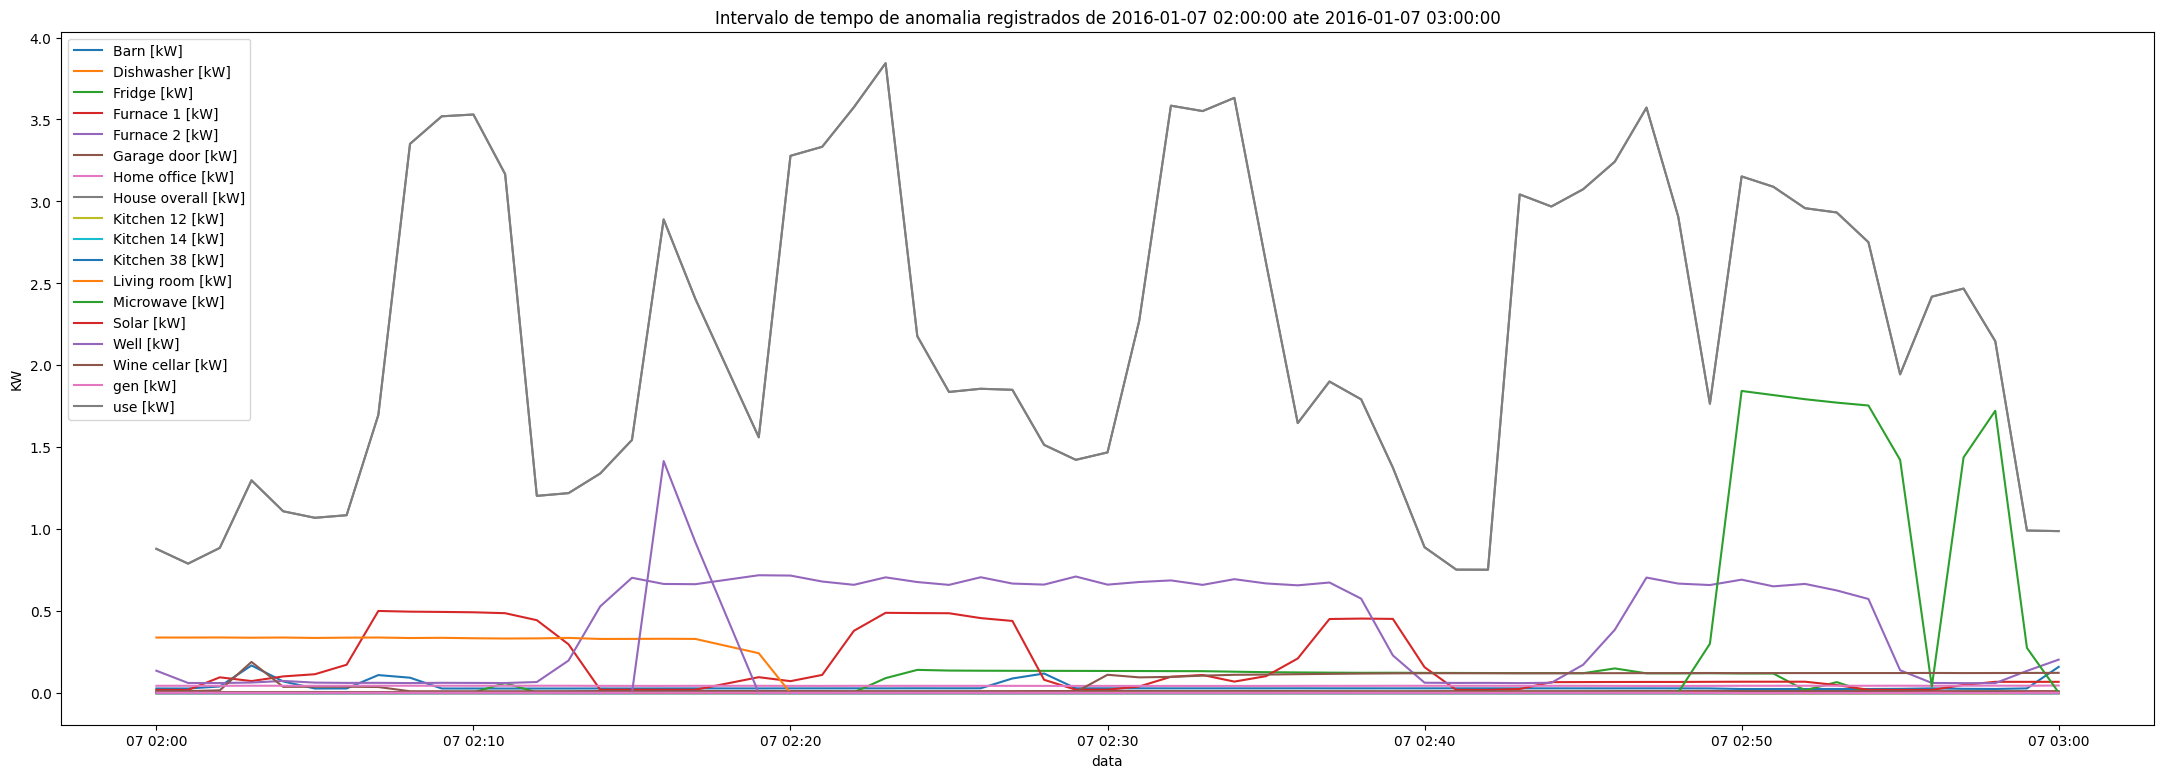

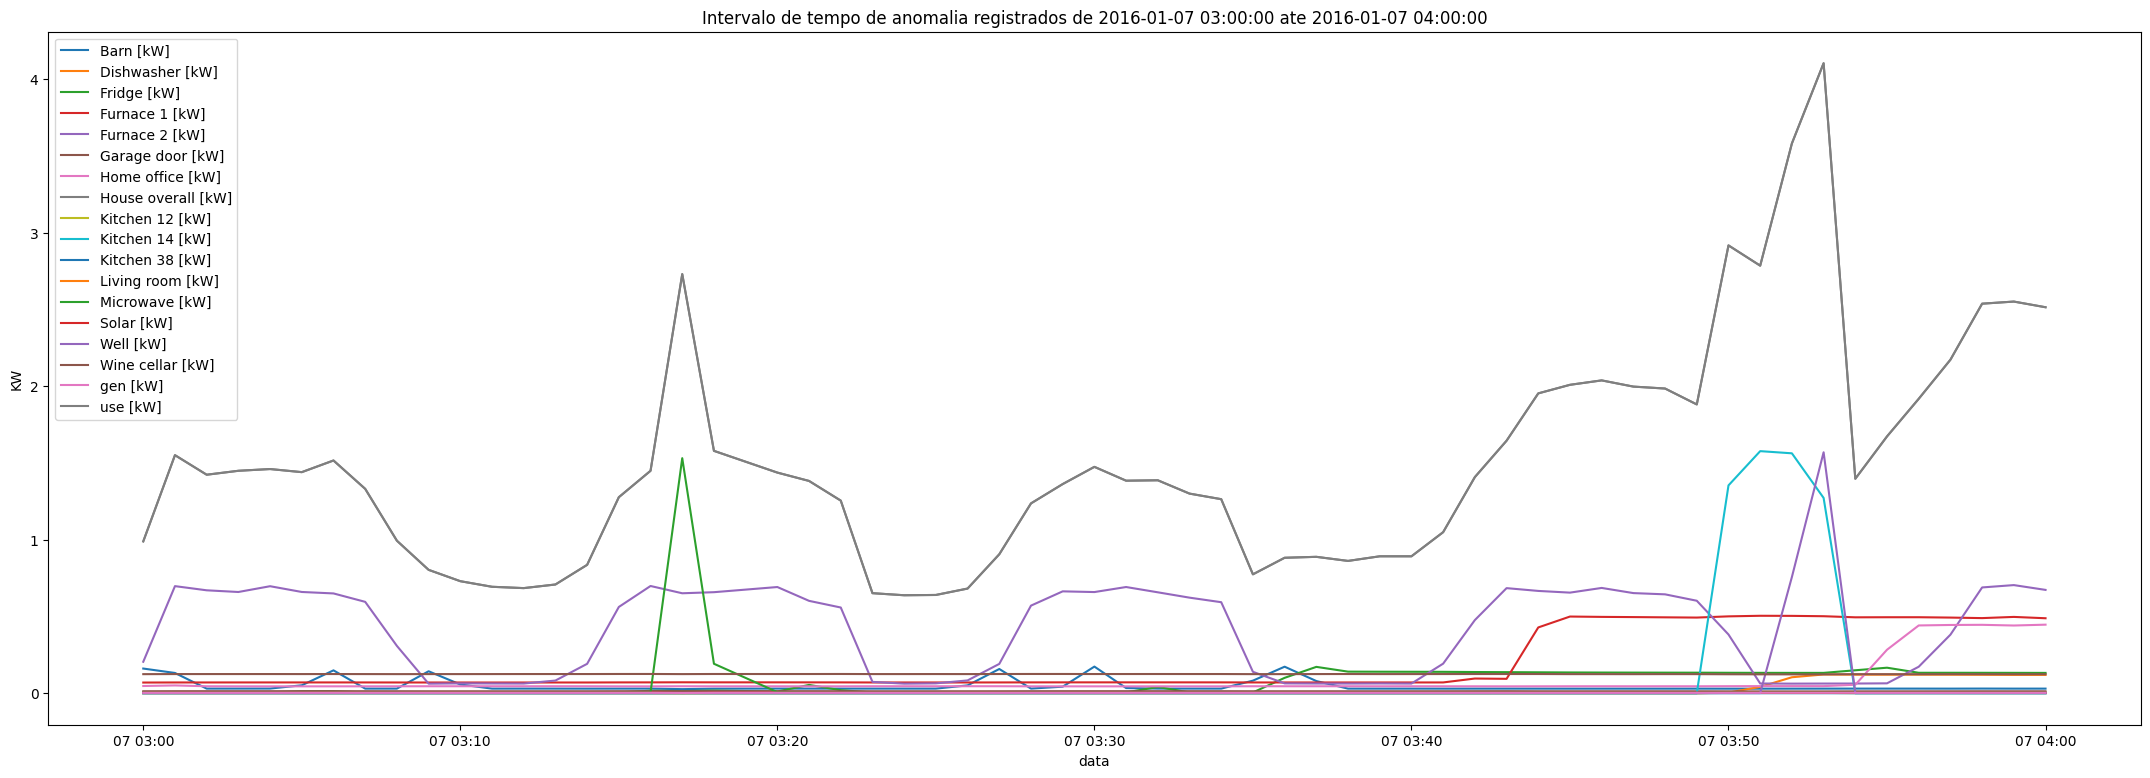

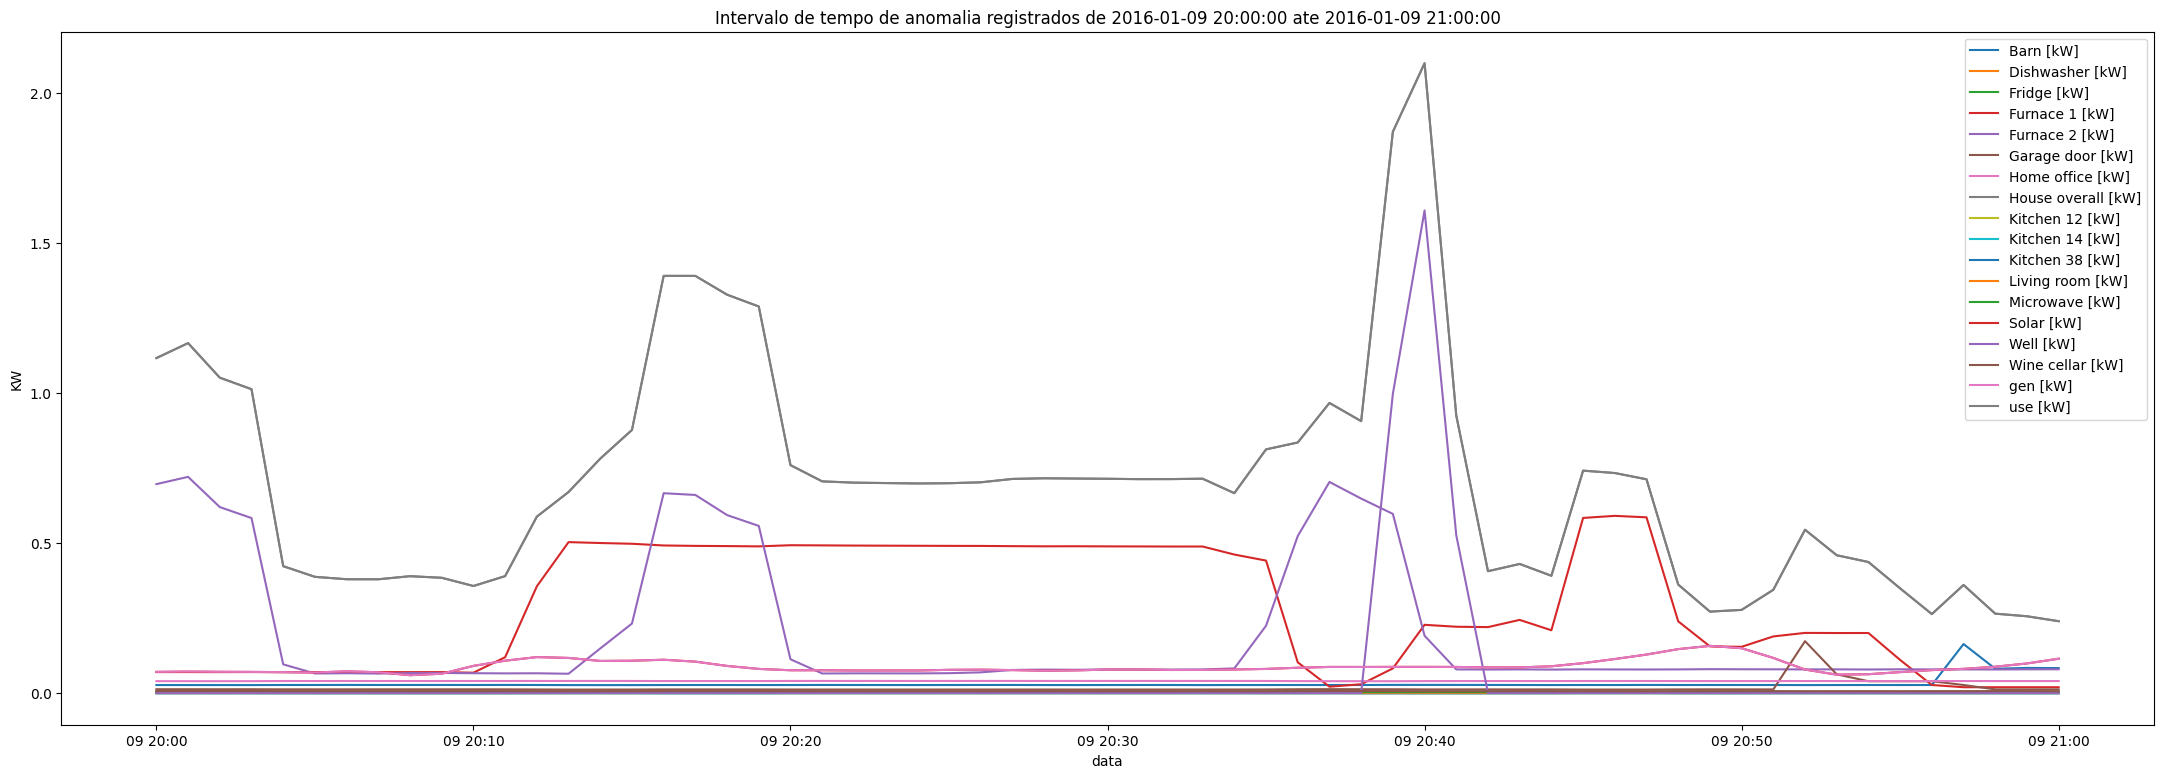

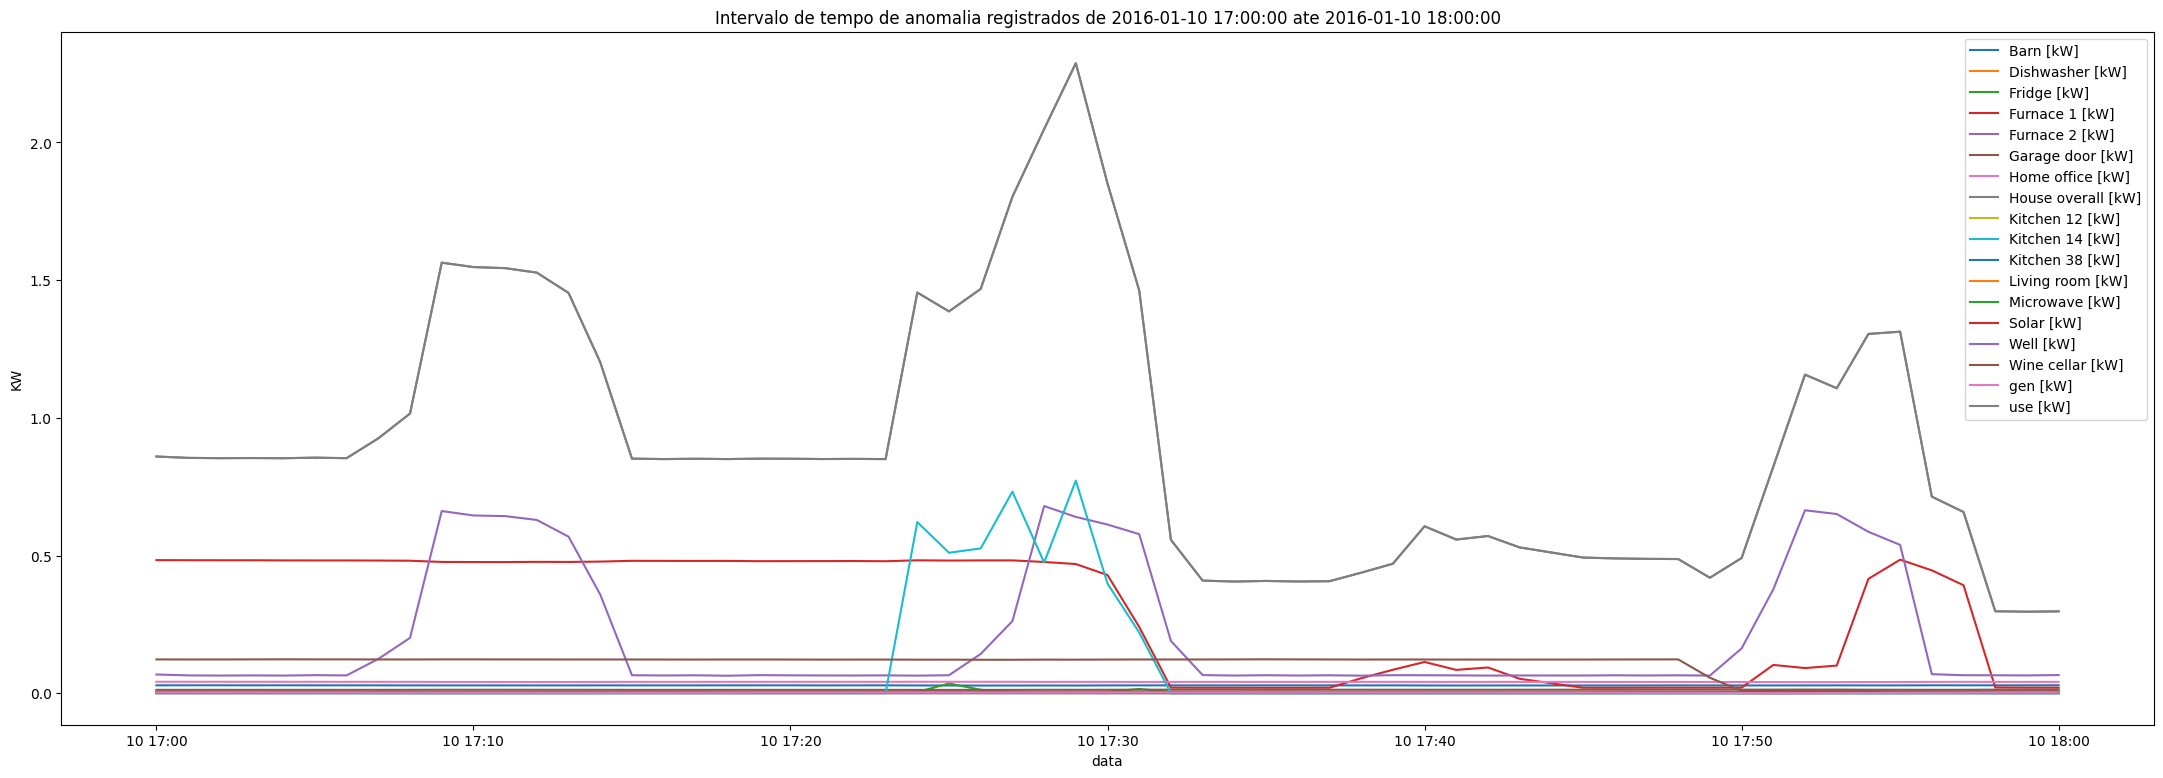

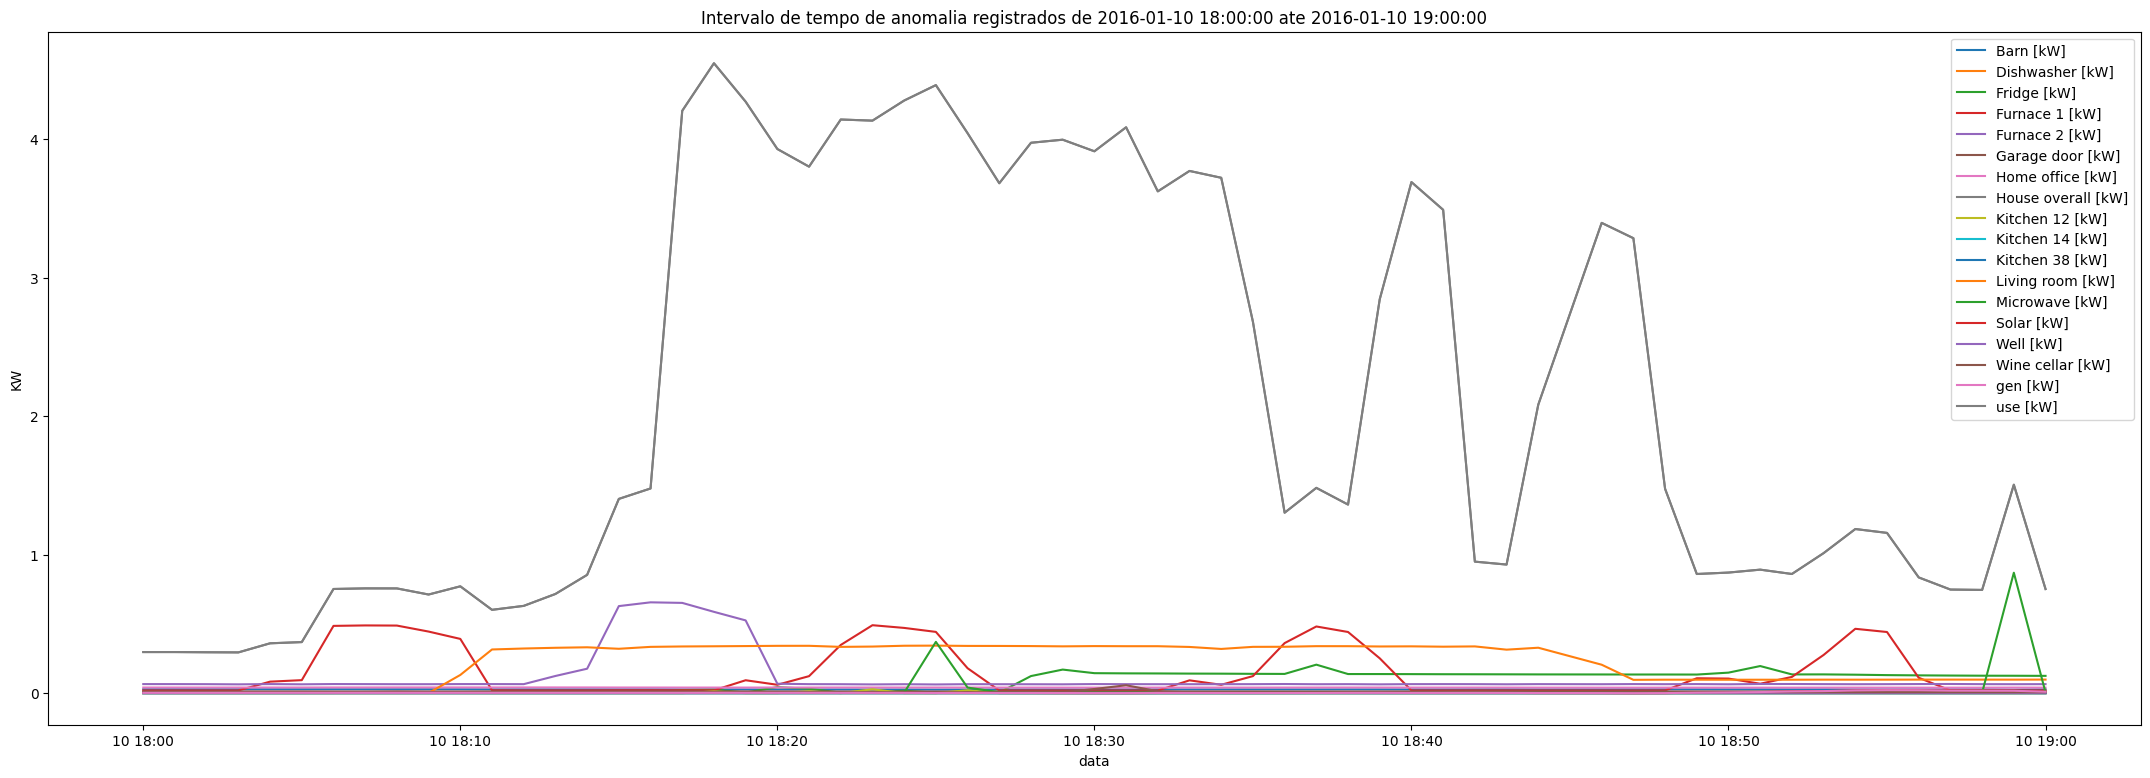

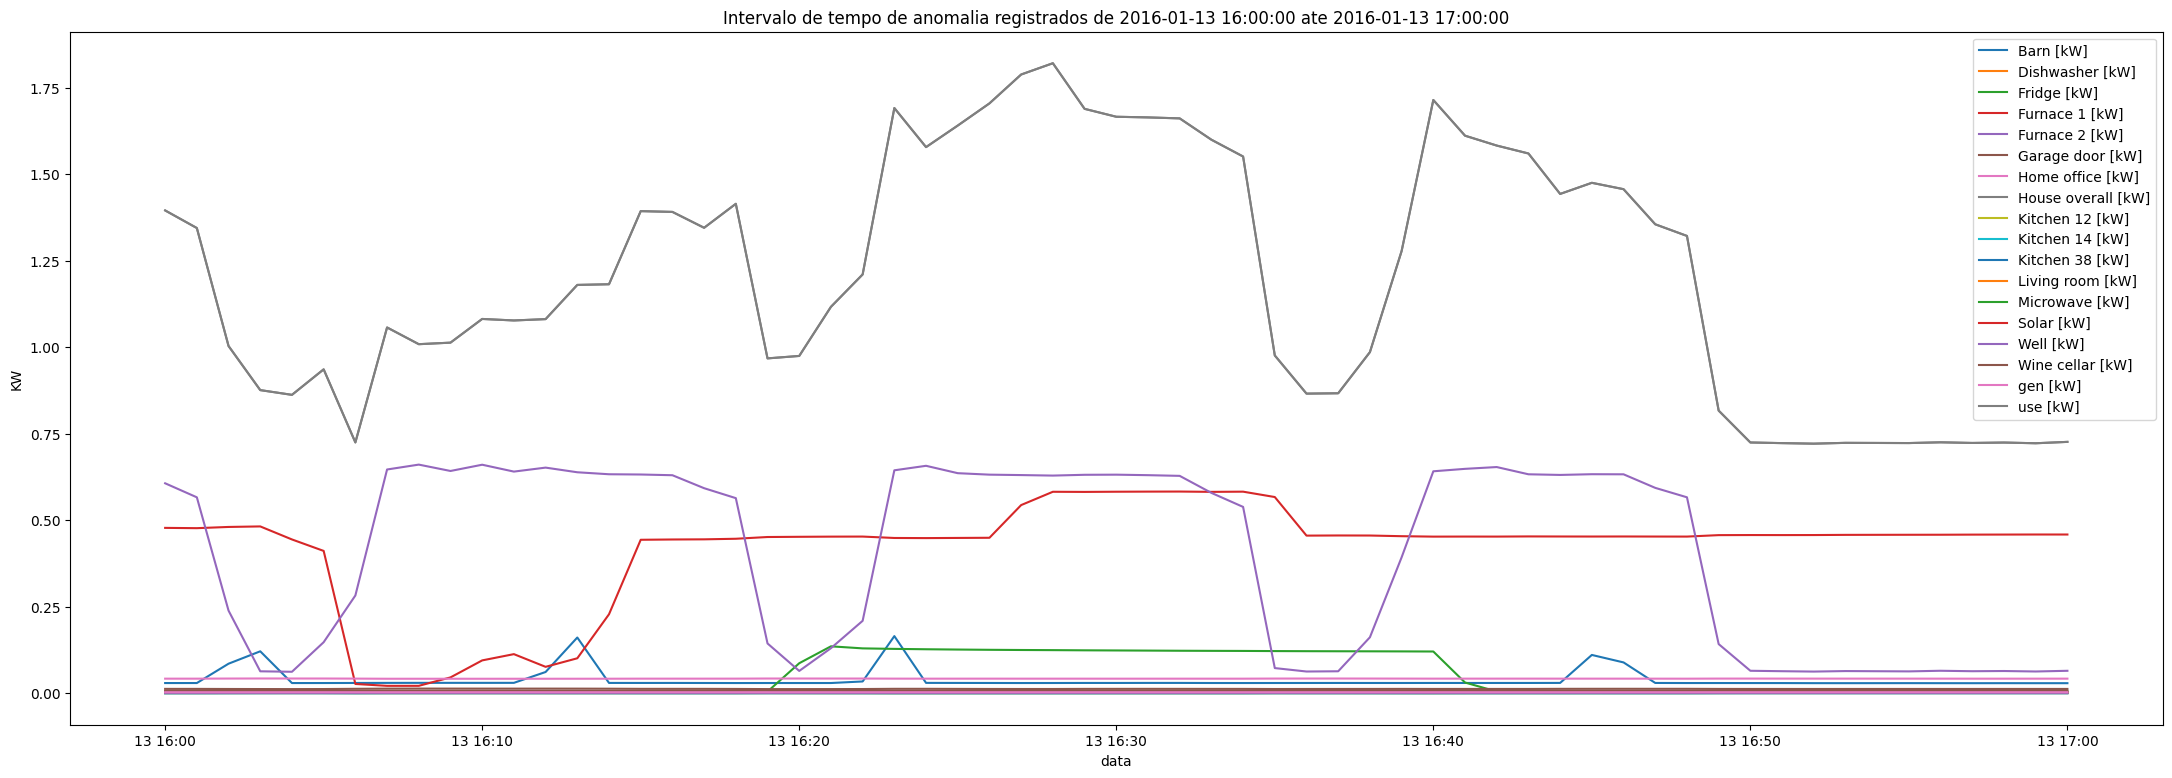

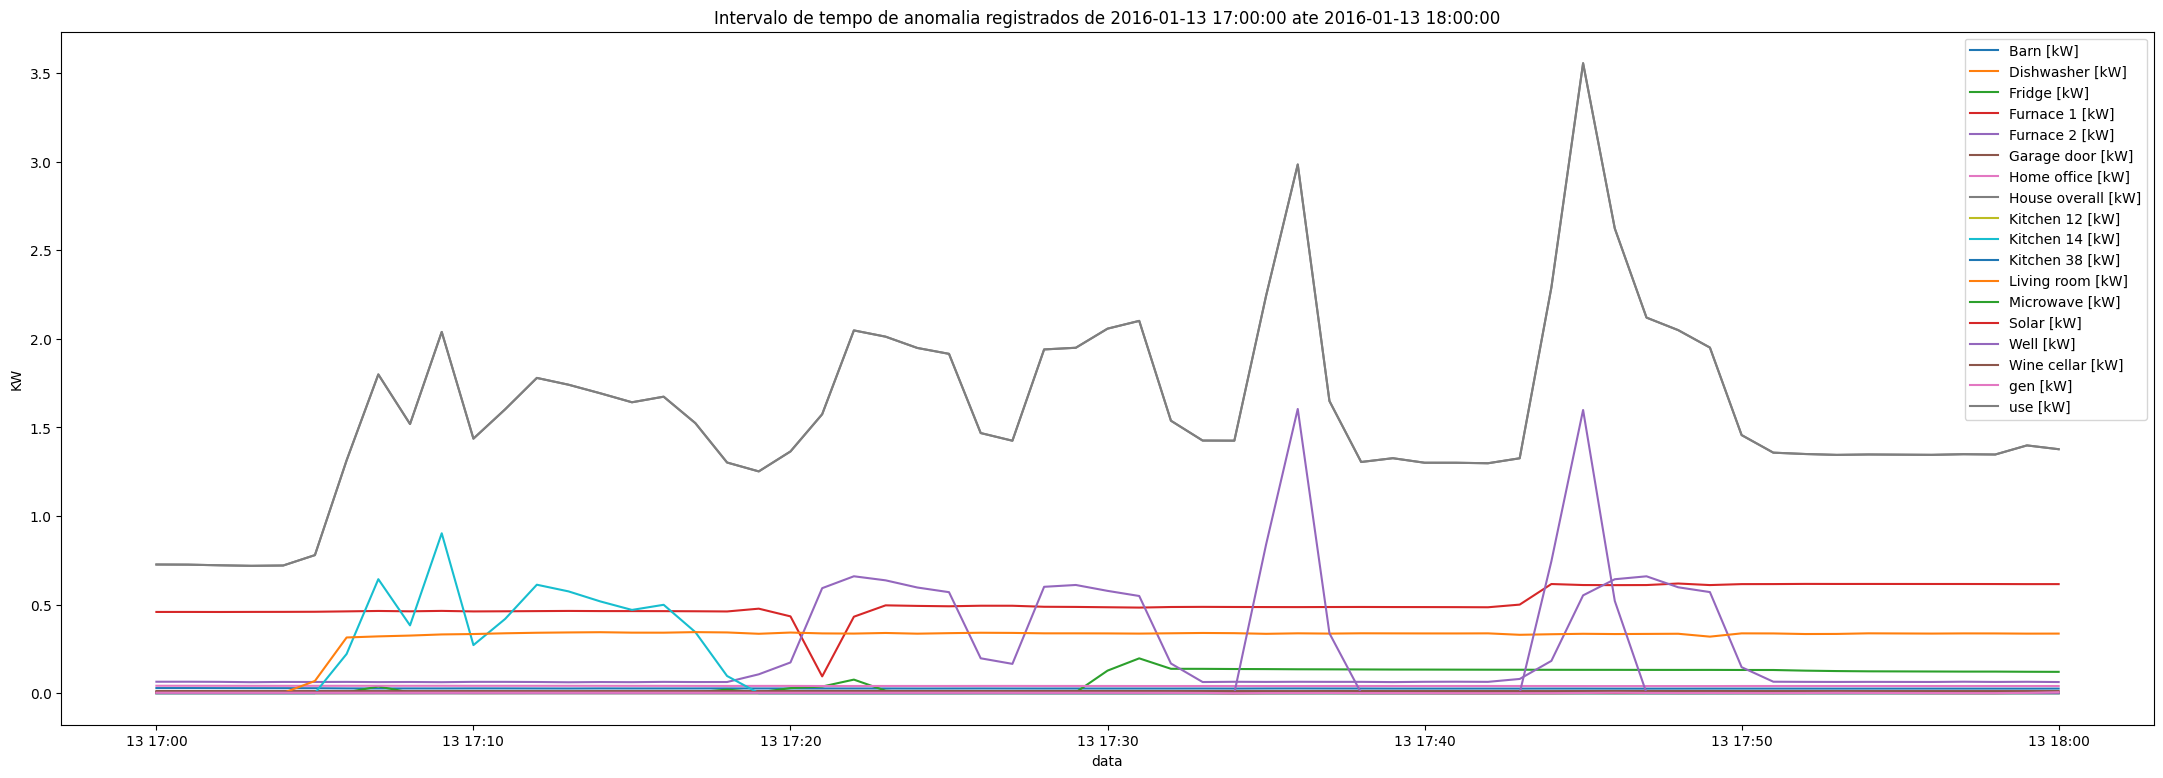

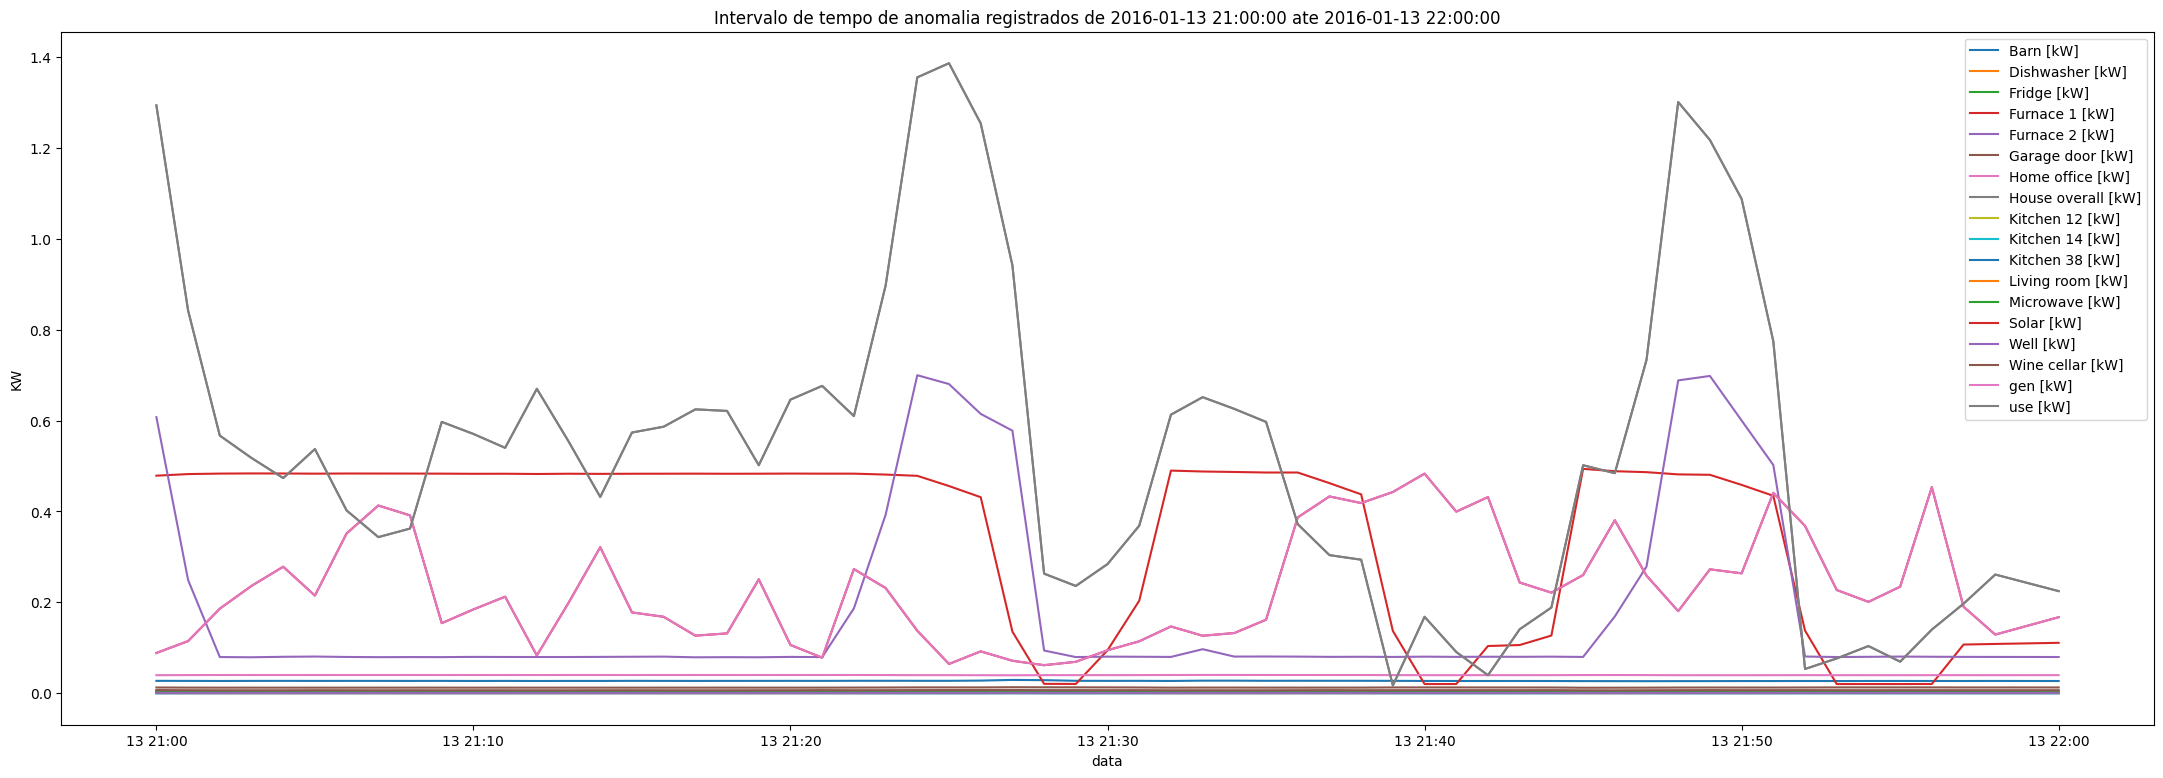

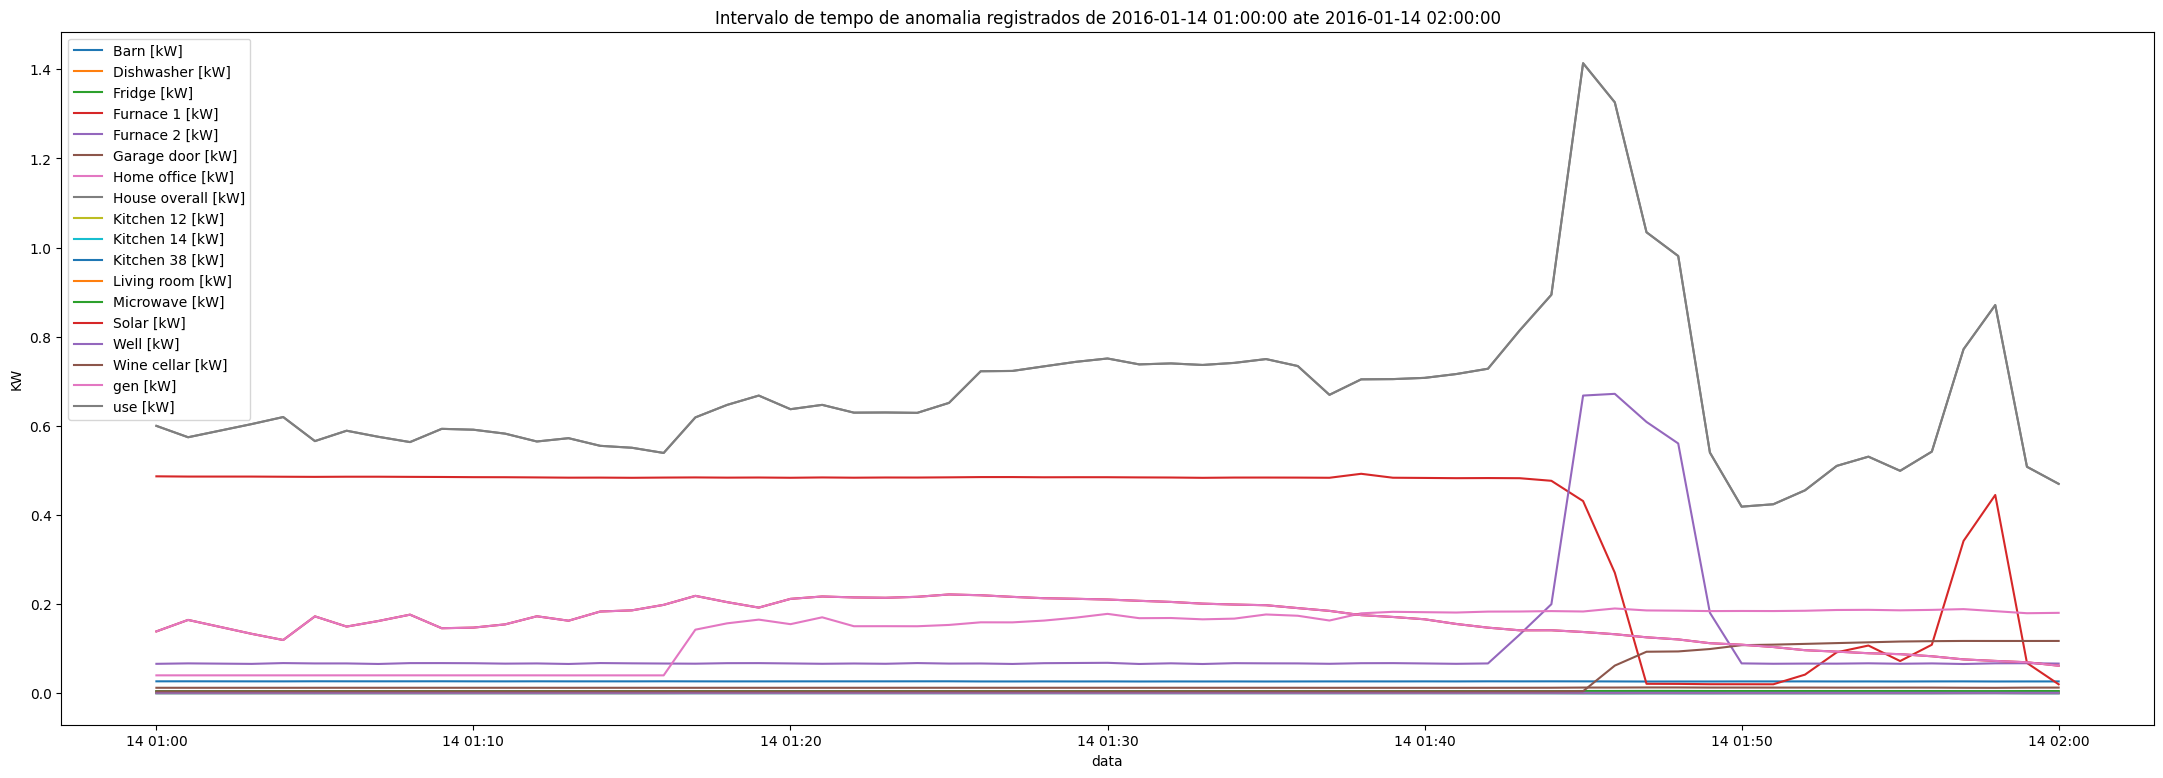

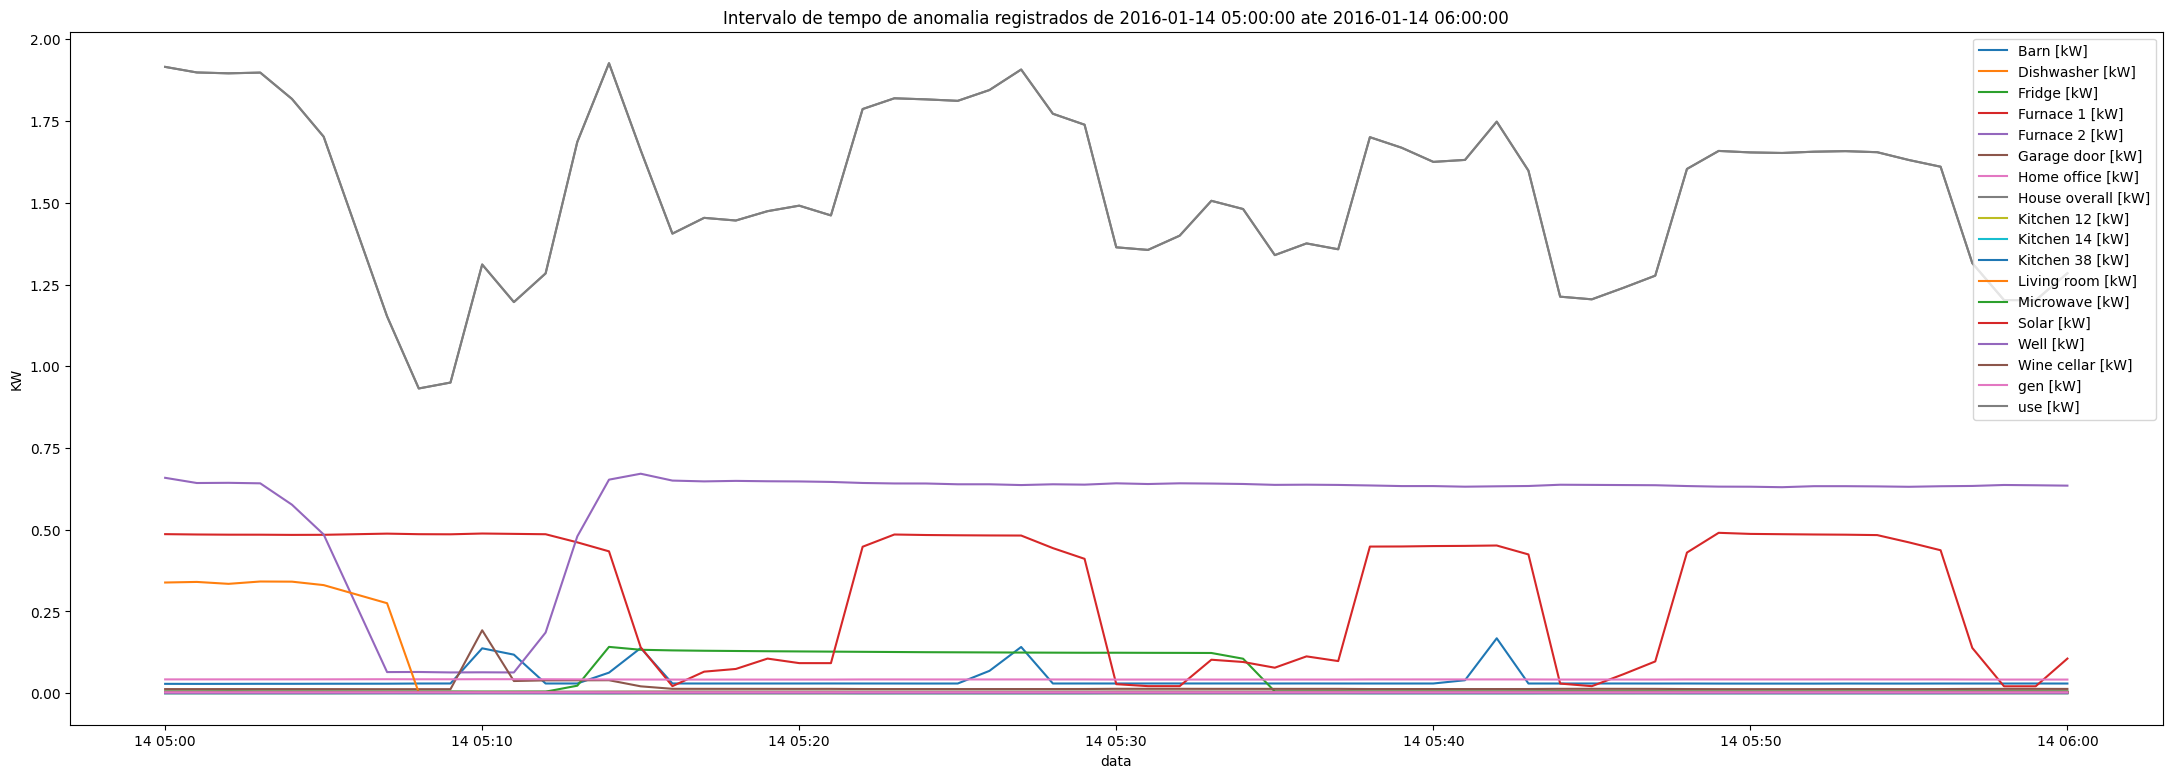

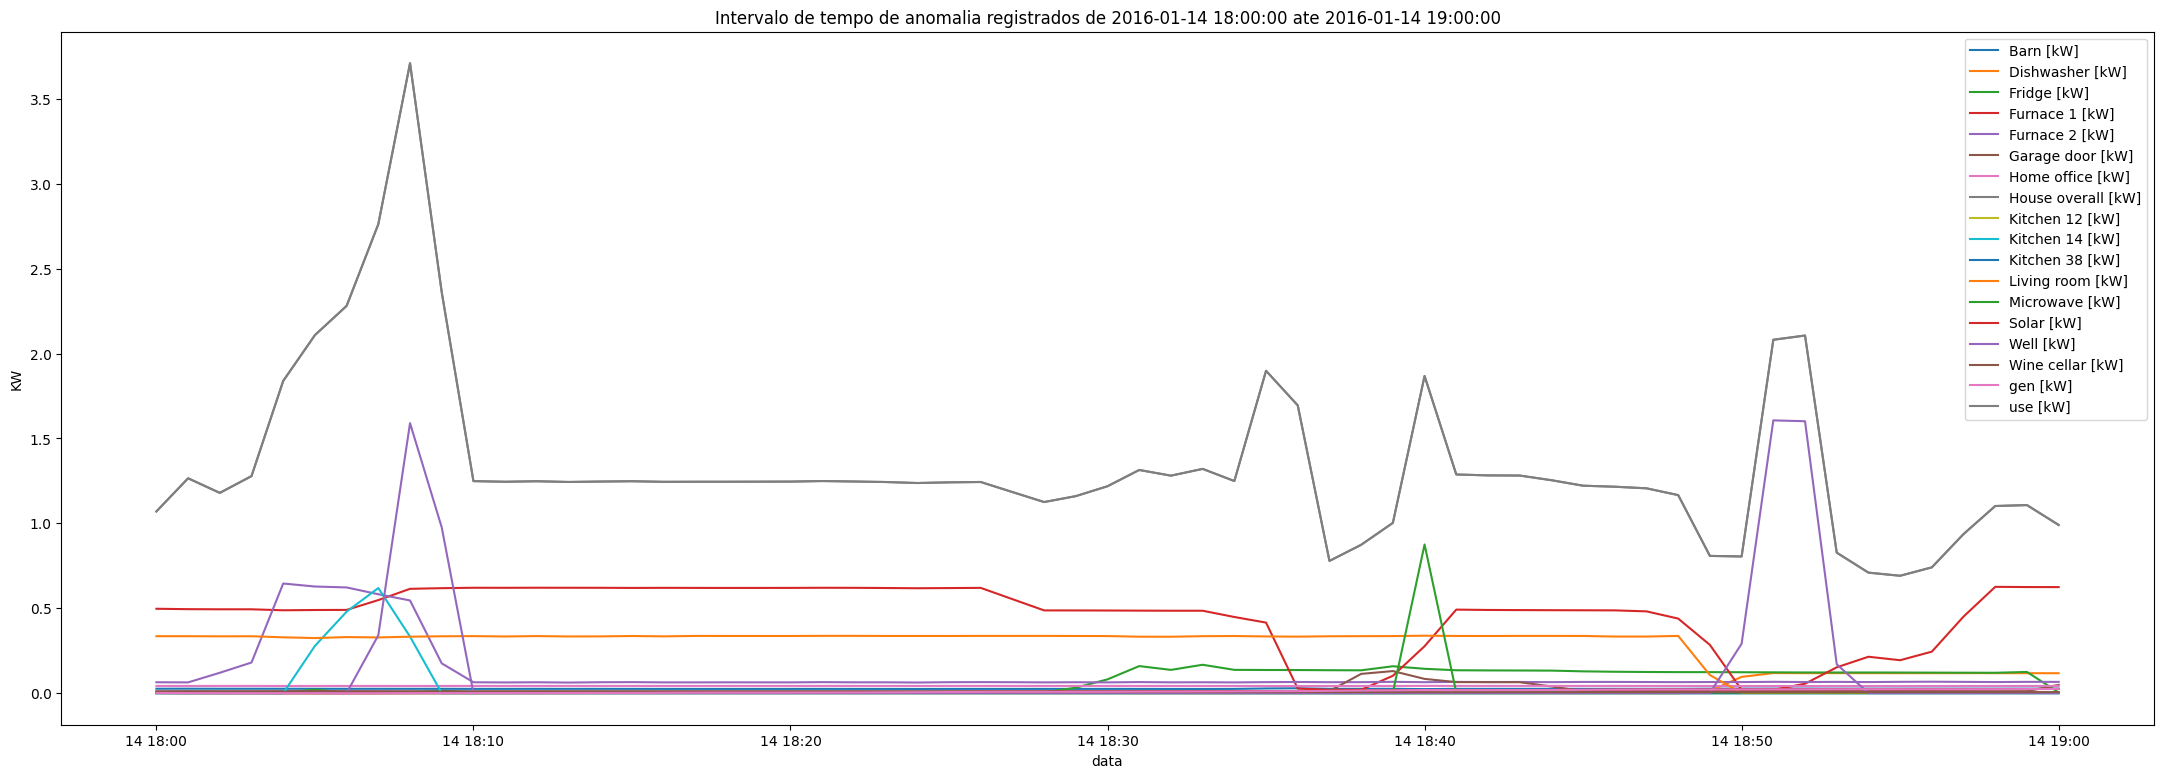

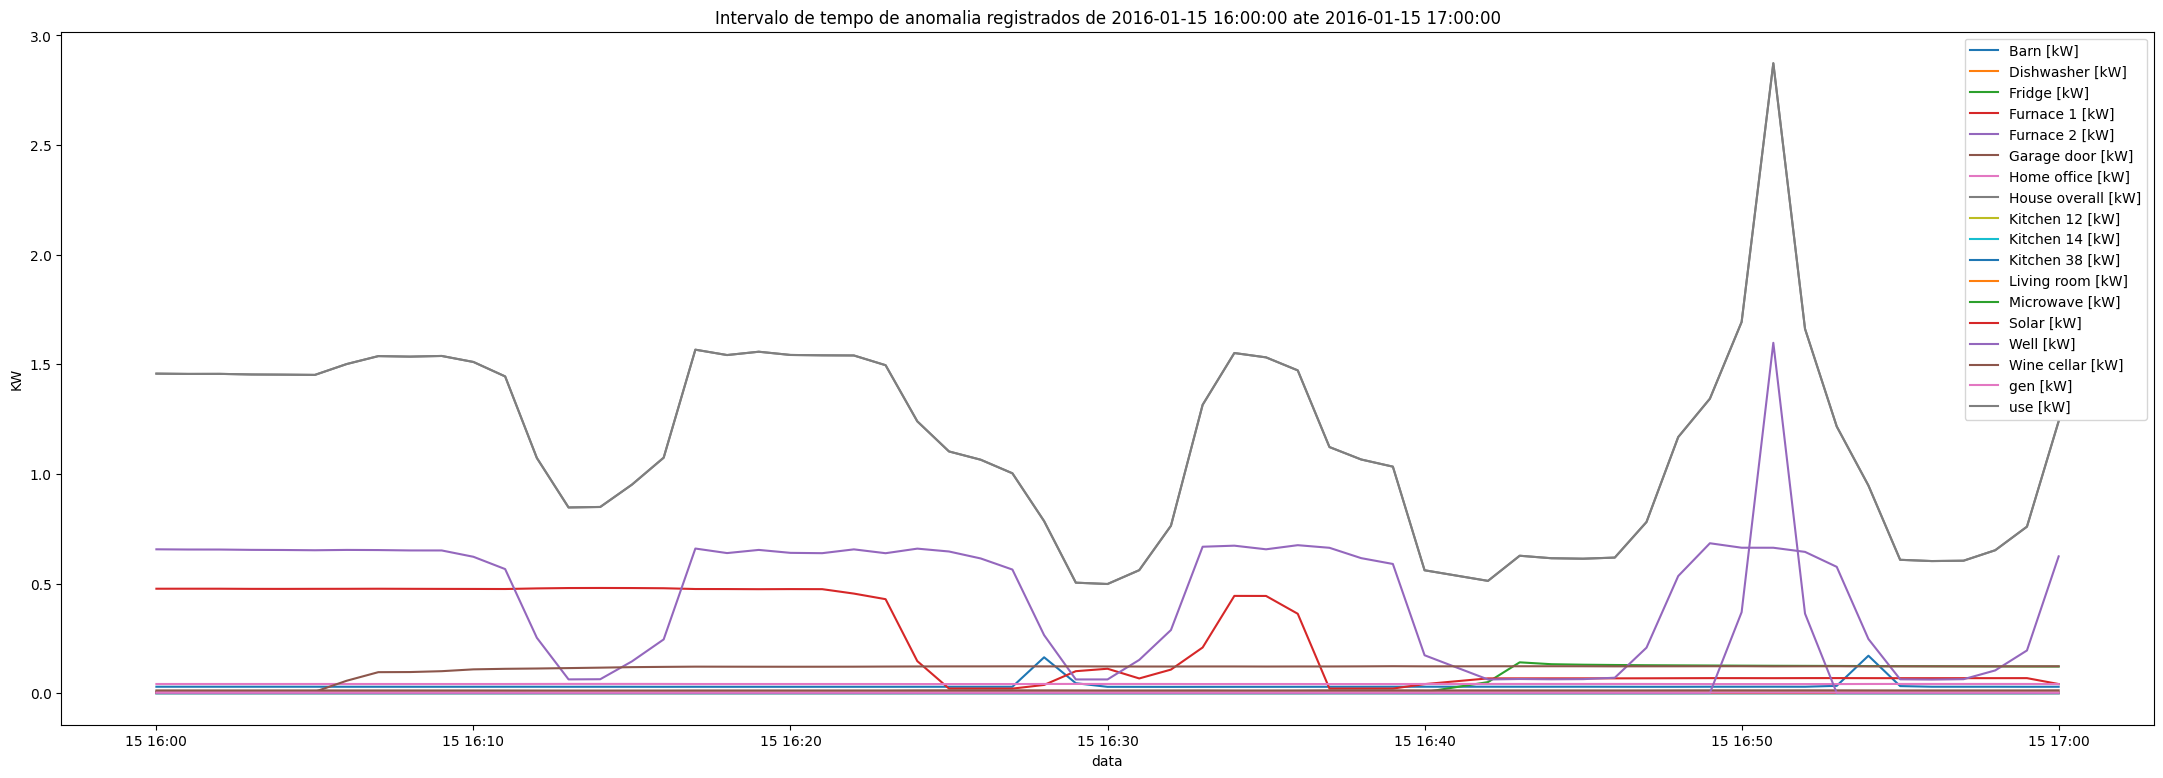

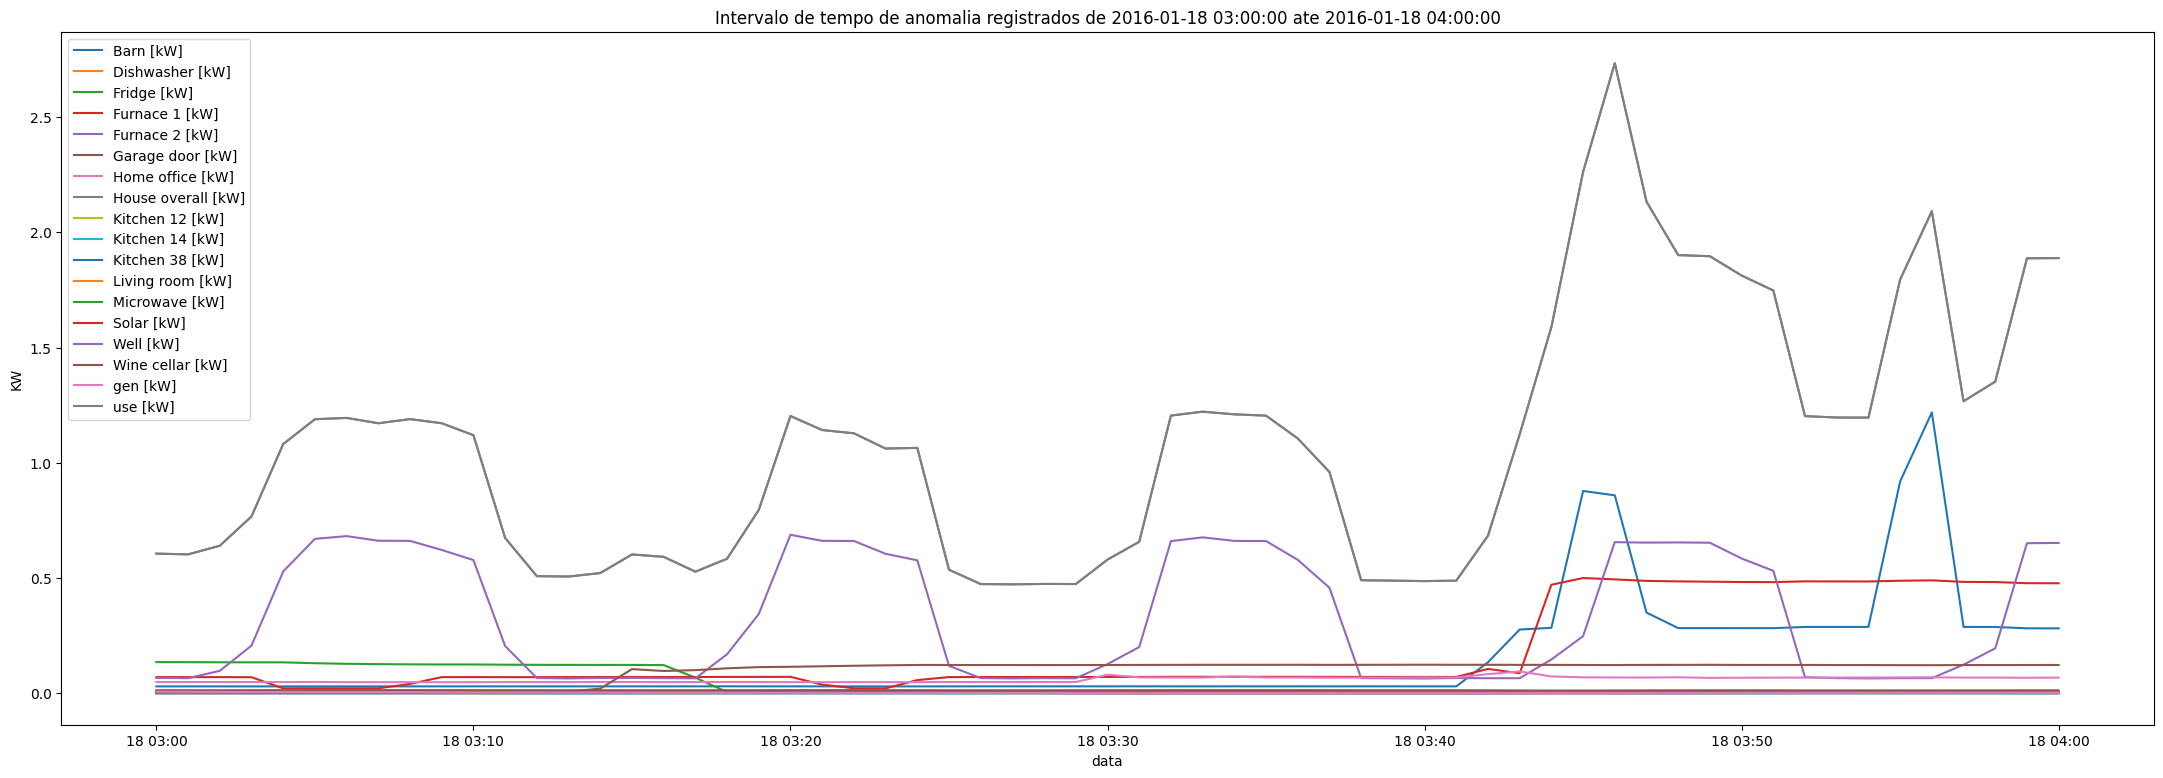

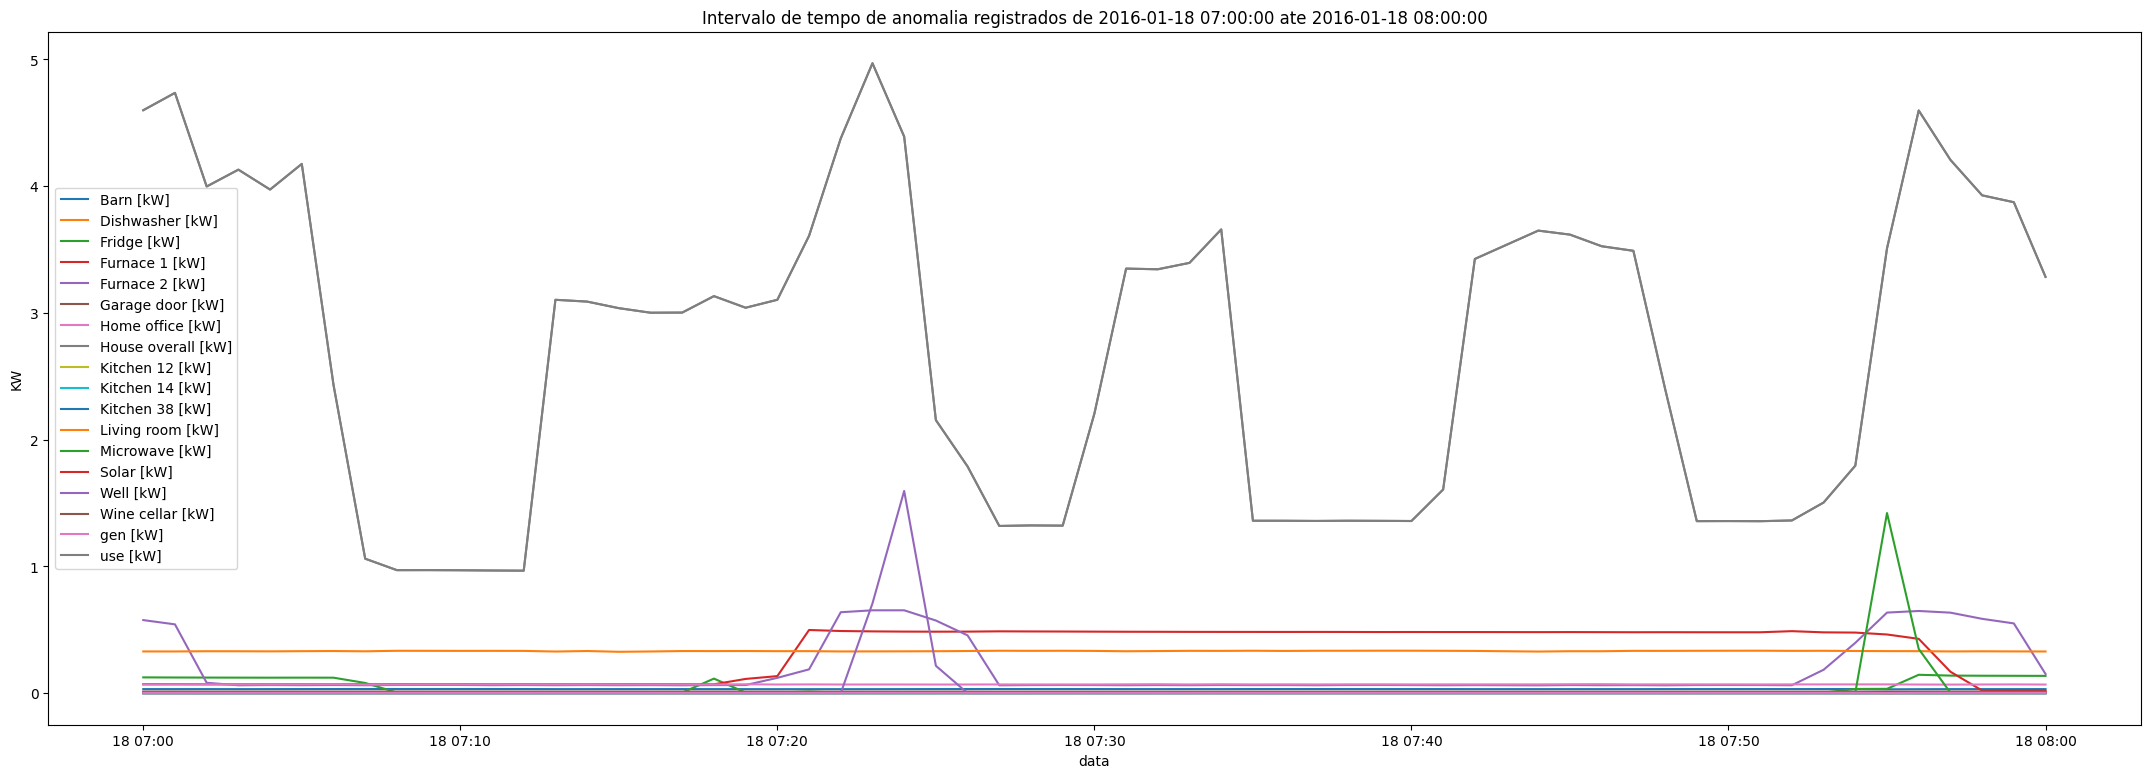

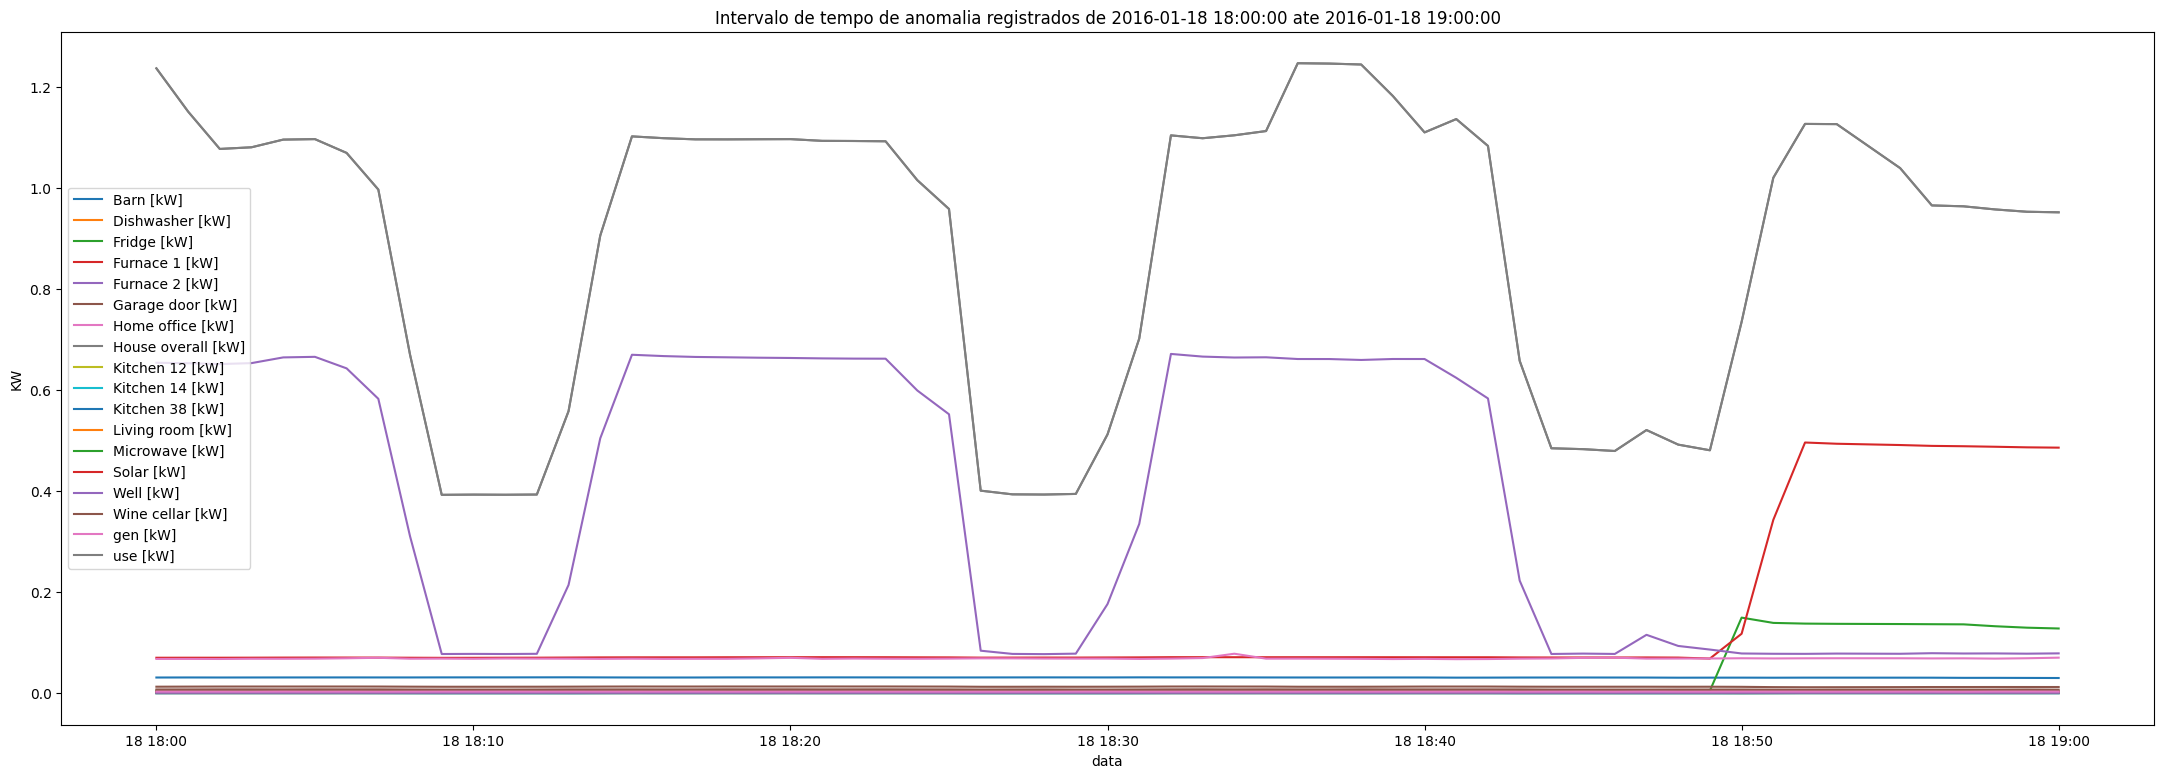

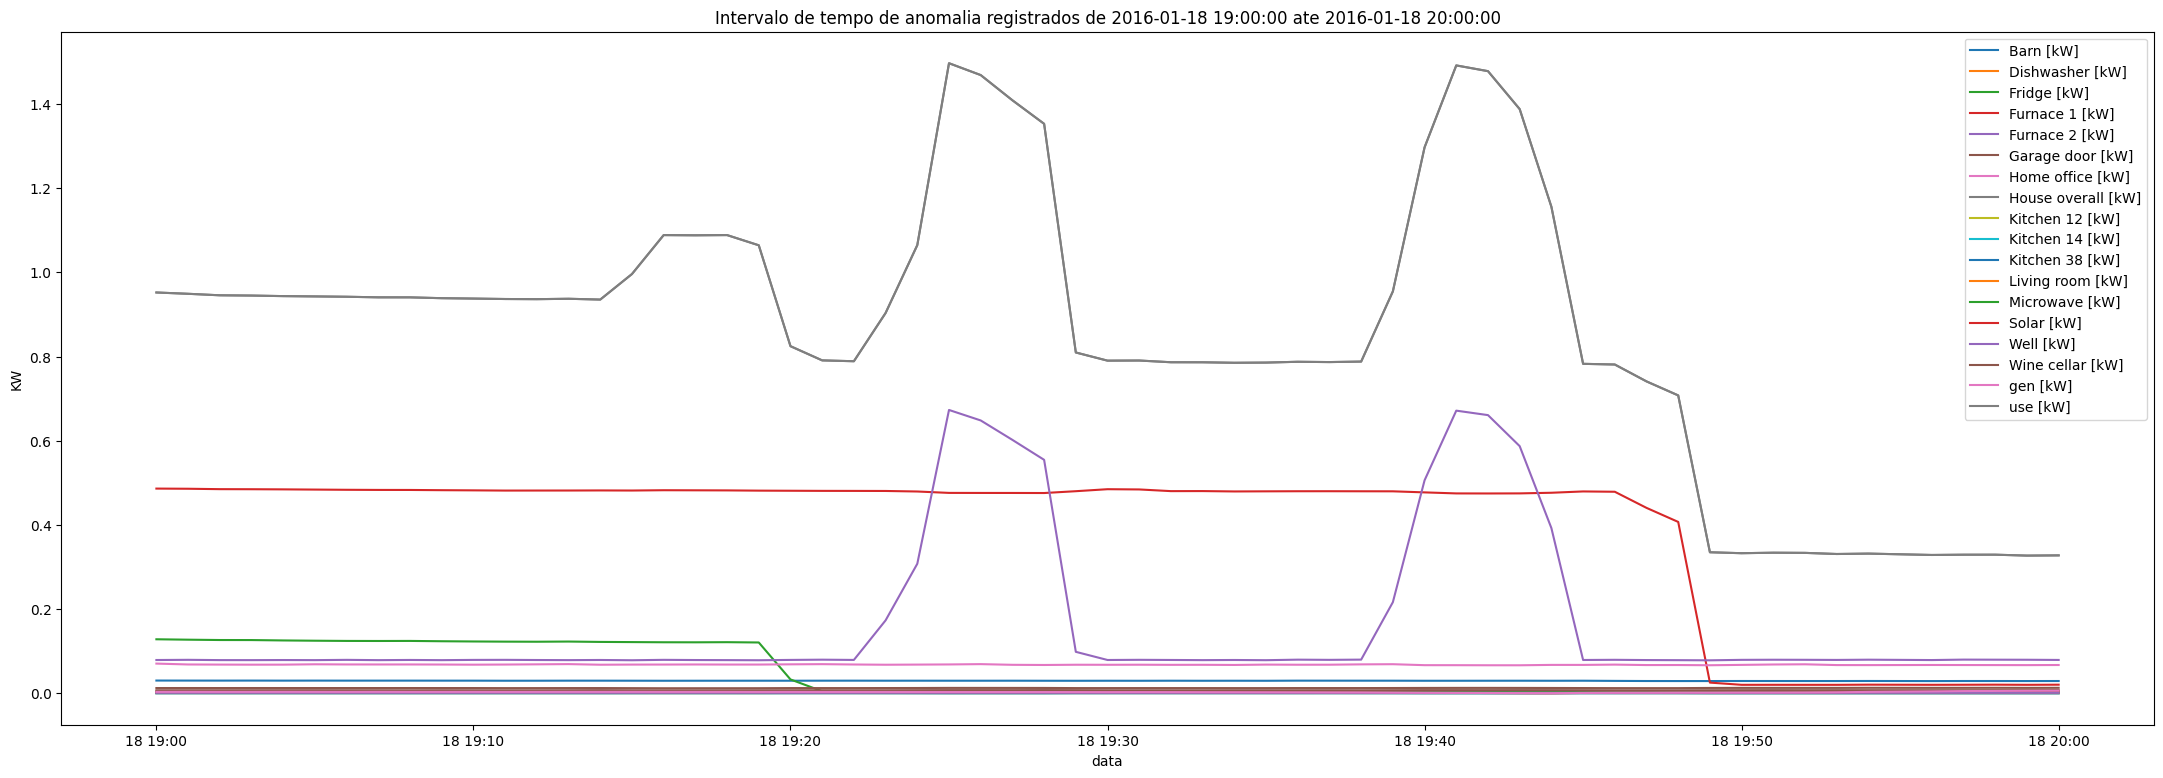

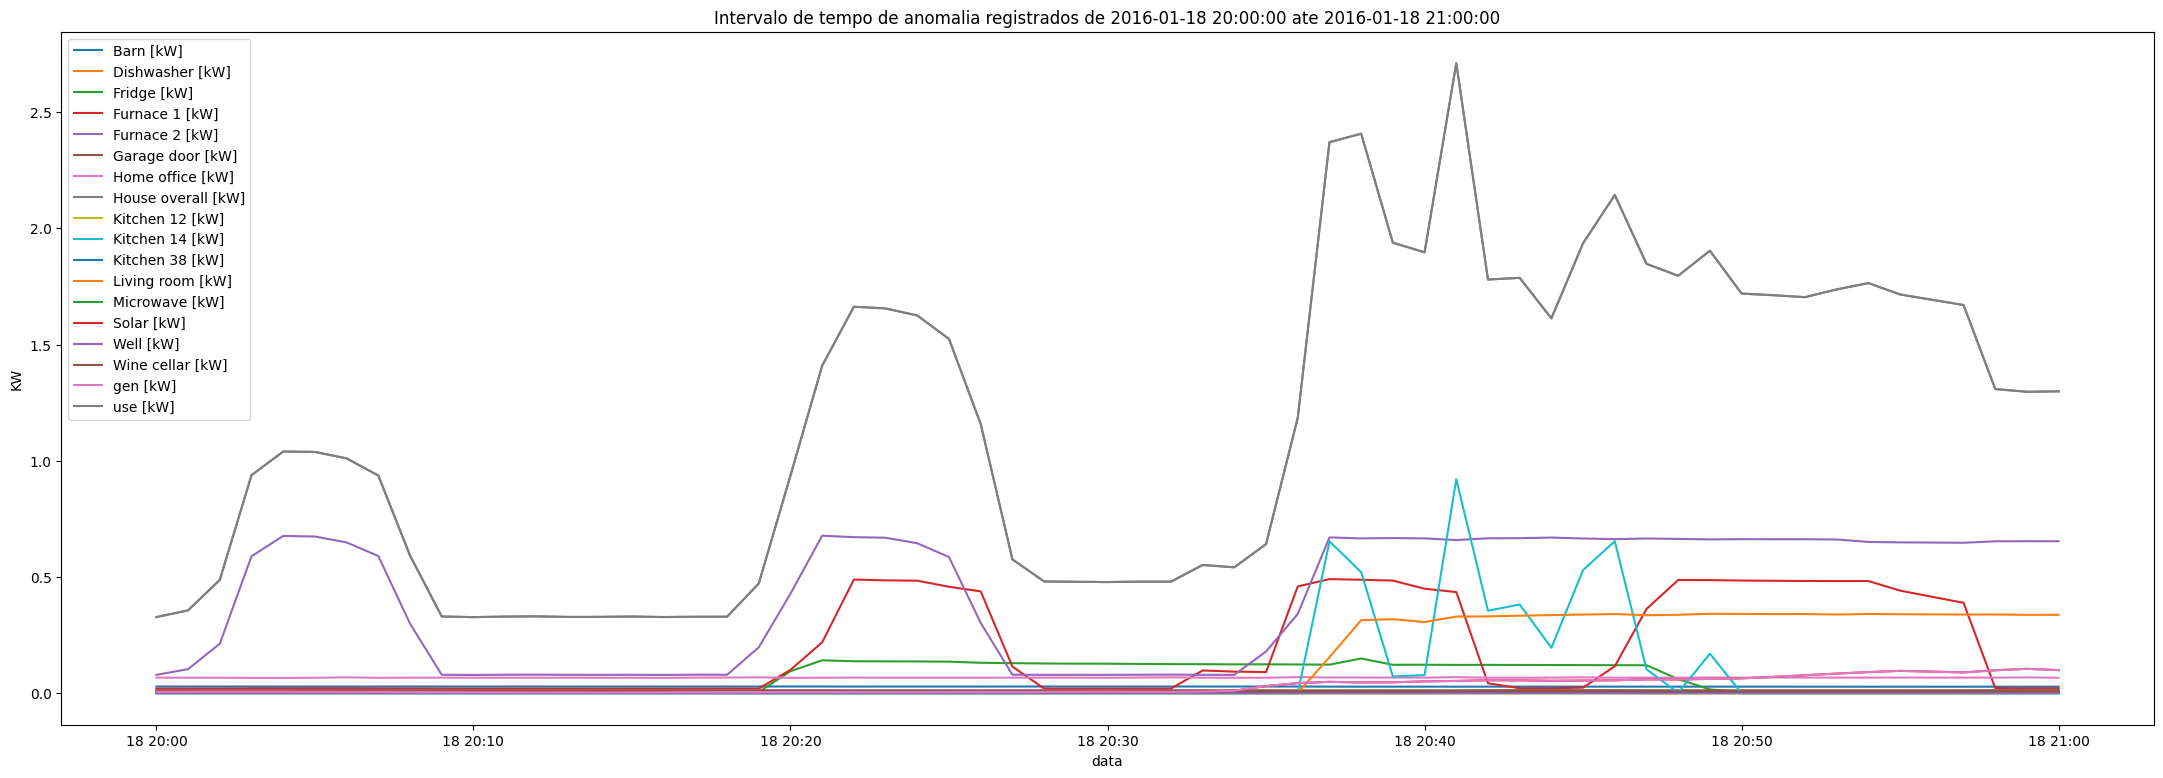

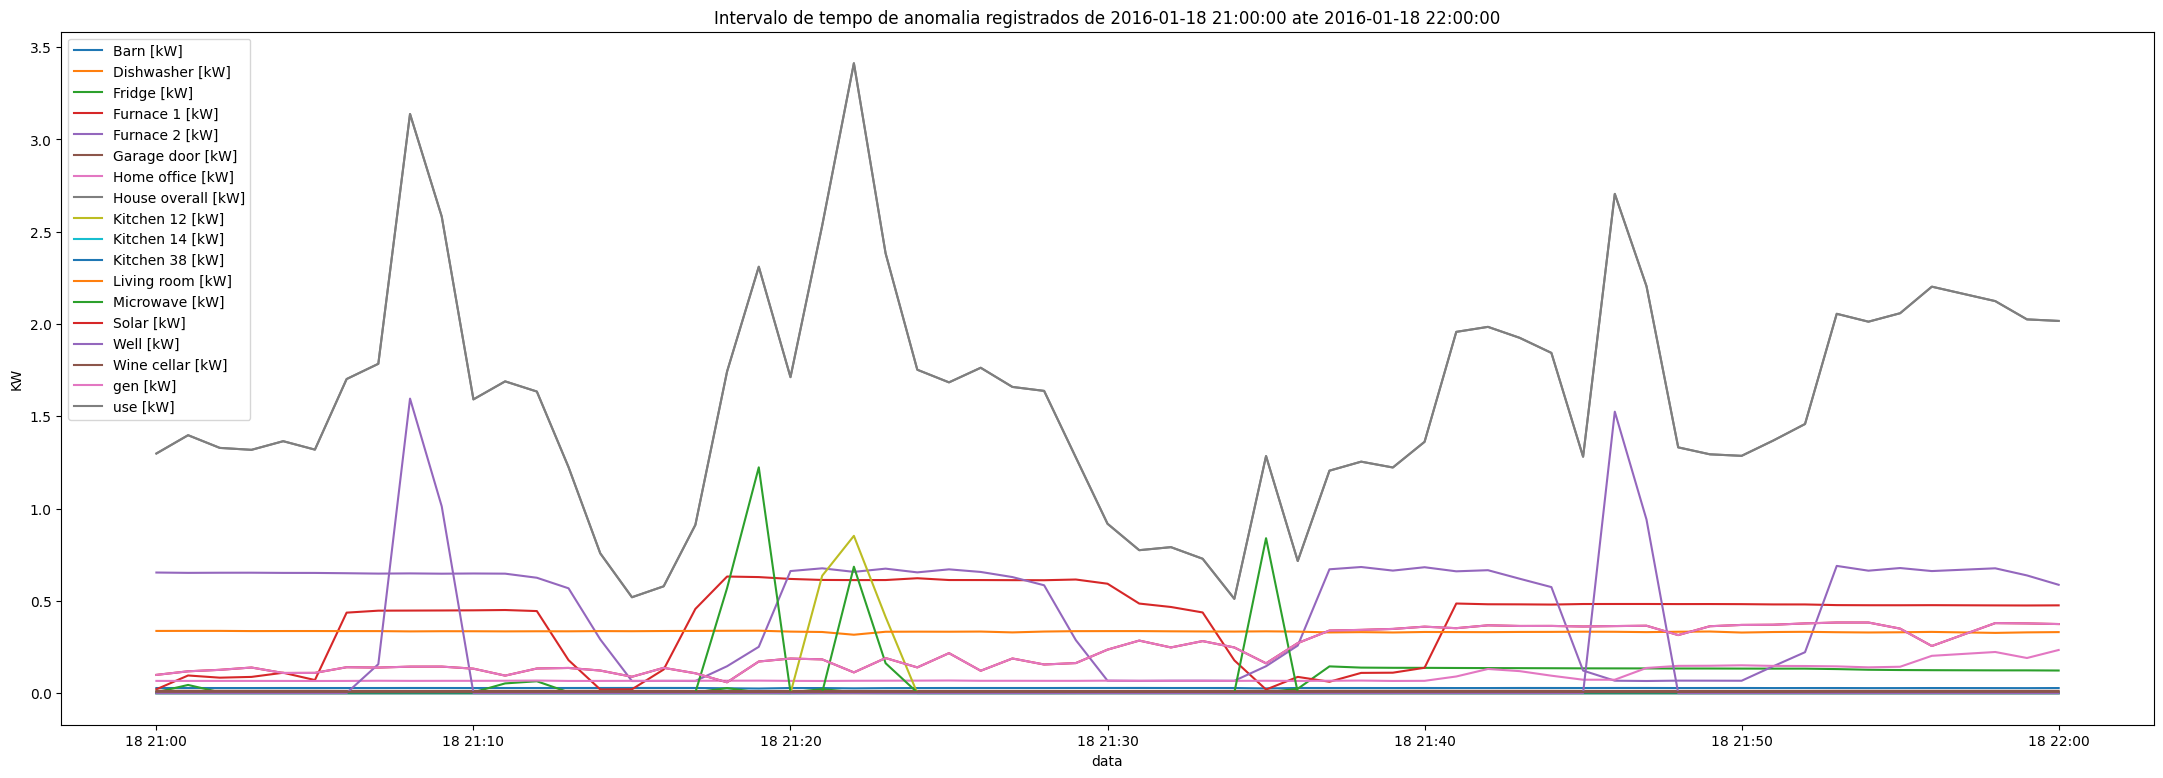

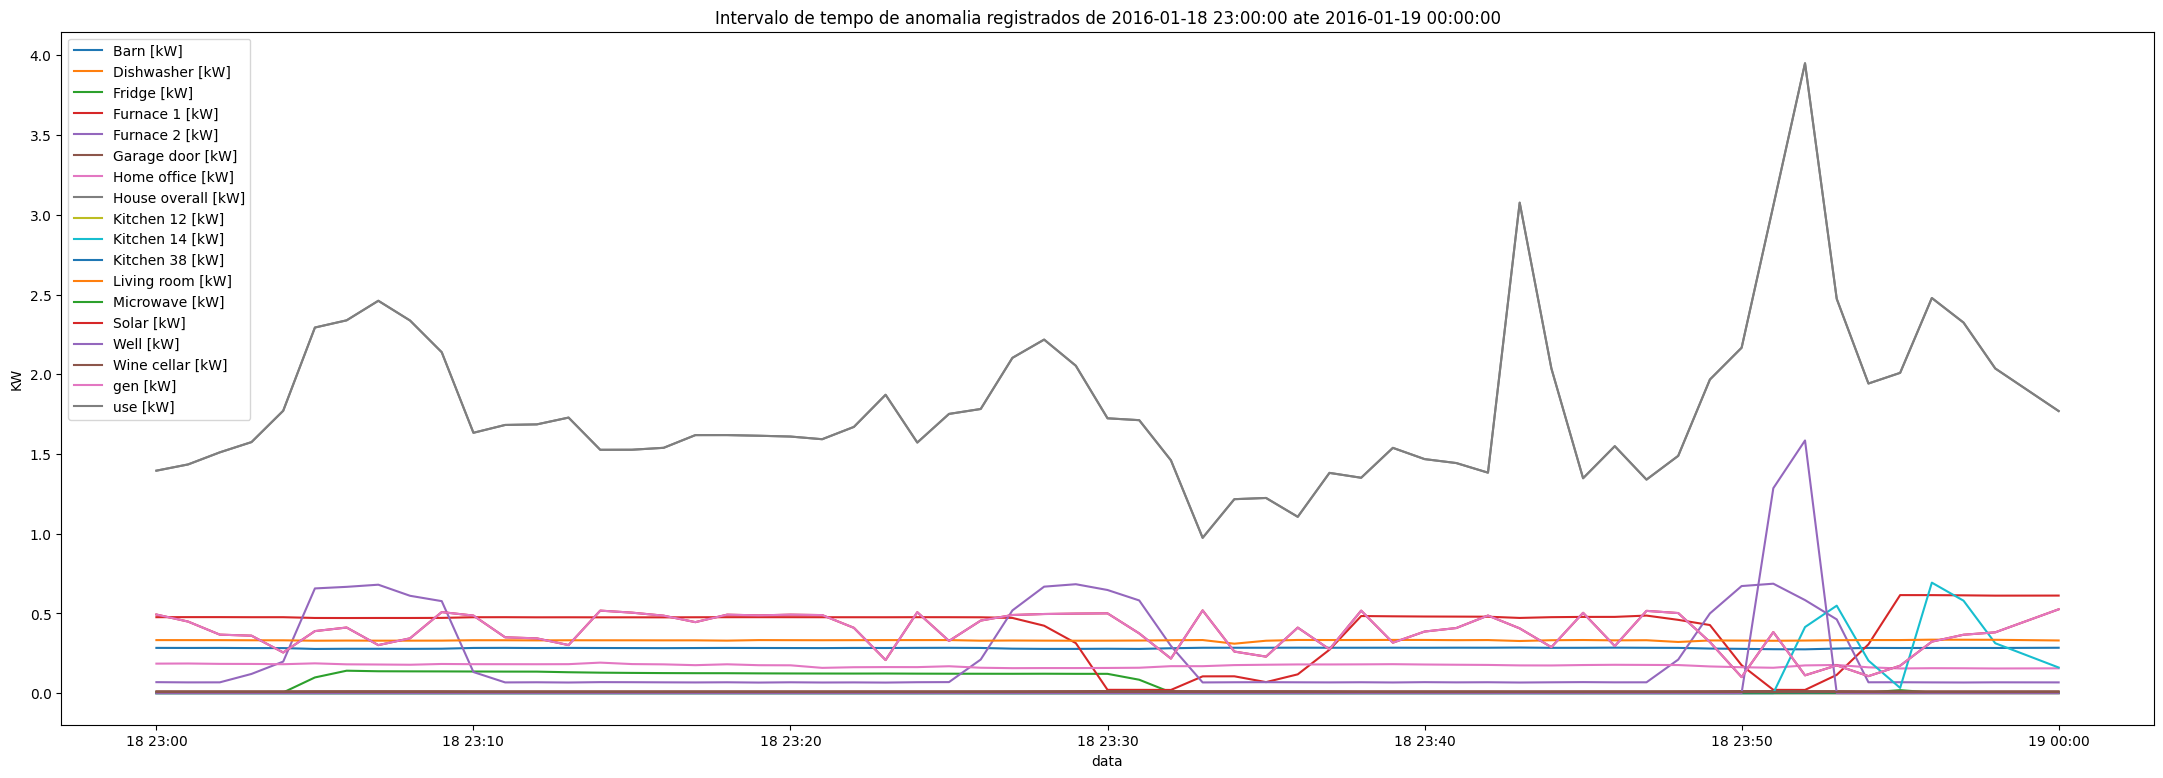

In [8]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))

def AllAnomaliesGraph():
    csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))
    for i in anomaly.index.to_list():

        a = encontrar_valor_em_dataframe(csv_original,subtrair_uma_hora(anomaly['datetime'][i]))
        b = encontrar_valor_em_dataframe(csv_original,anomaly['datetime'][i])
        df_temp = csv_original[a:b+1]
        df_temp2 = df_temp.drop(['datetime','apparentTemperature','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed'], axis=1)
        x = df_temp['datetime']
        t = 0
        plt.figure(figsize=(27, len(df_temp2.columns) * 0.5))
        for j in df_temp2.columns.tolist():

            if t < len(df_temp2.columns):
                y1 = df_temp2[df_temp2.columns[t]]
                plt.plot(x, y1, label=j)
                t+=1

            plt.title('Intervalo de tempo de anomalia registrados de '+ str( x[a]) + ' ate ' + str(x[b]))
            plt.xlabel('data')
            plt.ylabel('KW')
            plt.legend()
        # Exiba o gráfico
        # Defina as colunas que serão usadas como eixo x (no exemplo, 'Ano')
    plt.show()

def KwUsageGraph():
    csv_original = formatar_dataframeSemMerge(pd.read_csv('../FIles/HomeC.csv'))

    a = encontrar_valor_em_dataframe(csv_original,subtrair_uma_hora(anomaly['datetime'][18]))
    b = encontrar_valor_em_dataframe(csv_original,anomaly['datetime'][18])
    df_temp = csv_original[a:b+1]
    df_temp2 = pd.DataFrame({'use [kW]': df_temp.pop('use [kW]')})
    x = df_temp['datetime']
    y1 = df_temp2[df_temp2.columns[0]]
    
    fig, ax = plt.subplots(figsize=(30, 10))  # Ajuste o tamanho da figura conforme necessário
    ax.plot(x, y1, label=df_temp2.columns[0])
    
    # Configurar rótulos do eixo x
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    plt.xticks(rotation=45, ha='right')  # Rotação de 45 graus para evitar sobreposições
    
    # Configurar rótulos do eixo y
    #ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Intervalo aproximado de 10 rótulos no eixo Y
    
    plt.title('Intervalo de tempo de anomalia registrados de ' + str(x[a]) + ' até ' + str(x[b]))
    plt.xlabel('Data')
    plt.ylabel('KW')
    plt.legend()
    plt.tight_layout()  # Ajusta o espaçamento para evitar cortes no gráfico
    plt.show()

AllAnomaliesGraph()
#KwUsageGraph()